In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exis

In [3]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
import shutil
import random
from PIL import Image
import h5py
import cv2
import scipy.io as io
import glob
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib import cm as CM
import json
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from torch.nn.functional import interpolate
from torchvision import datasets, transforms
import time

In [4]:
root = "/kaggle/input/shanghaitech/ShanghaiTech"
part_A_train = os.path.join(root,'part_A/train_data','images')
part_A_test = os.path.join(root,'part_A/test_data','images')
path_sets = [part_A_train,part_A_test]

In [5]:
# ottieni tutte le path delle immagini
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, "*.jpg")):
        img_paths.append(img_path)

img_paths[:5]

['/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images/IMG_160.jpg',
 '/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images/IMG_233.jpg',
 '/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images/IMG_21.jpg',
 '/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images/IMG_289.jpg',
 '/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images/IMG_163.jpg']

In [6]:
# /kaggle/input/shanghaitech/ShanghaiTech/part_B/train_data/images/IMG_160.jpg
saving_path = "/kaggle/working/"
# /kaggle/input/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth/IMG_160.mat
# /kaggle/working/GT_IMG_160.h5
os.makedirs("train_data", exist_ok=True)
os.makedirs("test_data", exist_ok=True)

In [7]:
for img_path in tqdm(img_paths):
    train_or_test = img_path.split('/')[-3]  # "train_data" or "test_data"
    filename = img_path.split('/')[-1]
    saving_path_folder = os.path.join("/kaggle/working/", train_or_test, filename.replace(".jpg", ".h5").replace("IMG_", "GT_IMG_"))
    # break if h5 already exist
    if os.path.exists(saving_path_folder):
        continue
    mat = io.loadmat(img_path.replace(".jpg", ".mat").replace("images", "ground-truth").replace("IMG_", "GT_IMG_"))
    img = plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1
    k = gaussian_filter(k, 15)
    with h5py.File(saving_path_folder, 'w') as hf:
        hf['density'] = k

100%|██████████| 482/482 [00:43<00:00, 11.07it/s]


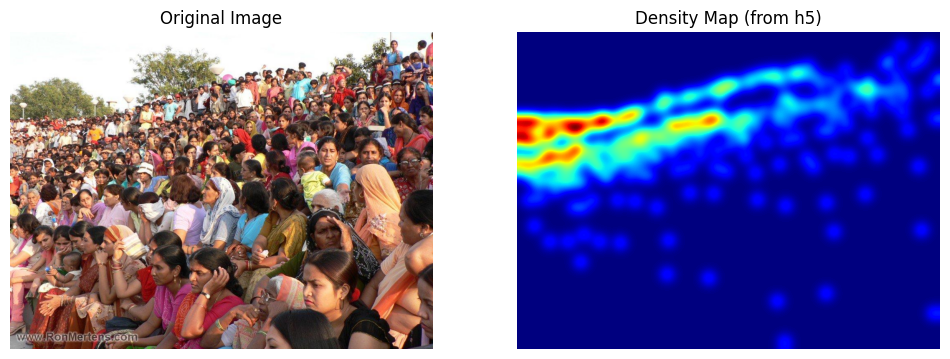

In [8]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# وظيفة لتحميل الصورة وخريطة الكثافة من ملف .h5
def visualize_saved_density_map(img_path):
    # استخراج اسم ملف h5 بناءً على الصورة
    train_or_test = img_path.split('/')[-3]  # "train_data" أو "test_data"
    filename = img_path.split('/')[-1].replace(".jpg", ".h5").replace("IMG_", "GT_IMG_")
    h5_path = os.path.join("/kaggle/working/", train_or_test, filename)

    # التحقق من وجود الملف
    if not os.path.exists(h5_path):
        print(f"ملف {h5_path} غير موجود!")
        return

    # تحميل الصورة الأصلية
    img = plt.imread(img_path)

    # تحميل خريطة الكثافة من ملف h5
    with h5py.File(h5_path, 'r') as hf:
        density_map = np.array(hf['density'])

    # **عرض الصورة الأصلية وخريطة الكثافة**
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # عرض الصورة الأصلية
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # عرض خريطة الكثافة
    axes[1].imshow(density_map, cmap='jet')
    axes[1].set_title("Density Map (from h5)")
    axes[1].axis("off")

    plt.show()

# مثال على الاستخدام
sample_img_path = img_paths[9]  # تحديد أي صورة من القائمة
visualize_saved_density_map(sample_img_path)


In [9]:
# path to folder that contains images
img_folder = os.path.join(root, "part_A/train_data/images")
 
# path to the final json file
output_json = 'all_imgs.json'

img_list = []

for img_path in glob.glob(os.path.join(img_folder, '*.jpg')):
    img_list.append(img_path)

# img_list = img_list[:int(len(img_list)*0.5)]
train_test_split = 0.8
img_train = img_list[:int(len(img_list)*train_test_split)]
img_val = img_list[int(len(img_list)*train_test_split):]

with open(saving_path + "train_imgs.json",'w') as f:
    json.dump(img_train, f)

with open(saving_path + "val_imgs.json",'w') as f:
    json.dump(img_val, f)

In [10]:
len(img_train), len(img_val)

(240, 60)

In [11]:
import os
import h5py
import random
import numpy as np
import cv2
from PIL import Image

def apply_gamma_and_clahe(np_image, gamma=1.5):
    # تصحيح غاما
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")
    gamma_corrected = cv2.LUT(np_image, table)

    # تطبيق CLAHE على كل قناة في الصورة
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels = cv2.split(gamma_corrected)
    clahe_channels = [clahe.apply(c) if len(c.shape) == 2 else c for c in channels]
    result = cv2.merge(clahe_channels)

    return result

def load_and_preprocess_data(image_path, is_training=True):
    dataset_split = image_path.split('/')[-3]
    image_filename = image_path.split('/')[-1]

    ground_truth_path = os.path.join(
        "/kaggle/working/",
        dataset_split,
        image_filename.replace(".jpg", ".h5").replace("IMG_", "GT_IMG_")
    )

    input_image = Image.open(image_path).convert('RGB')

    with h5py.File(ground_truth_path, 'r') as ground_truth_file:
        density_map = np.asarray(ground_truth_file['density'])

    if is_training:
        crop_ratio = 0.5
        crop_dimensions = (
            int(input_image.size[0] * crop_ratio),
            int(input_image.size[1] * crop_ratio)
        )

        random_value = random.random()
        if random_value < 0.25:
            crop_x, crop_y = 0, 0
        elif random_value < 0.5:
            crop_x, crop_y = int(input_image.size[0] * crop_ratio), 0
        elif random_value < 0.75:
            crop_x, crop_y = 0, int(input_image.size[1] * crop_ratio)
        else:
            crop_x, crop_y = int(input_image.size[0] * crop_ratio), int(input_image.size[1] * crop_ratio)

        input_image = input_image.crop((crop_x, crop_y, crop_dimensions[0] + crop_x, crop_dimensions[1] + crop_y))
        density_map = density_map[crop_y:(crop_dimensions[1] + crop_y), crop_x:(crop_dimensions[0] + crop_x)]

        if random.random() > 0.8:
            density_map = np.fliplr(density_map)
            input_image = input_image.transpose(Image.FLIP_LEFT_RIGHT)

        # تحويل الصورة إلى NumPy وتطبيق gamma + CLAHE
        input_image_np = np.array(input_image)
        input_image_np = cv2.cvtColor(input_image_np, cv2.COLOR_RGB2BGR)  # تحويل BGR → RGB (OpenCV format)
        filtered_image_np = apply_gamma_and_clahe(input_image_np)
        input_image = Image.fromarray(cv2.cvtColor(filtered_image_np, cv2.COLOR_BGR2RGB))  # تحويل مرة أخرى إلى PIL

    resized_density = cv2.resize(
        density_map,
        (int(density_map.shape[1] / 8), int(density_map.shape[0] / 8)),
        interpolation=cv2.INTER_CUBIC
    ) * 64

    return input_image, resized_density


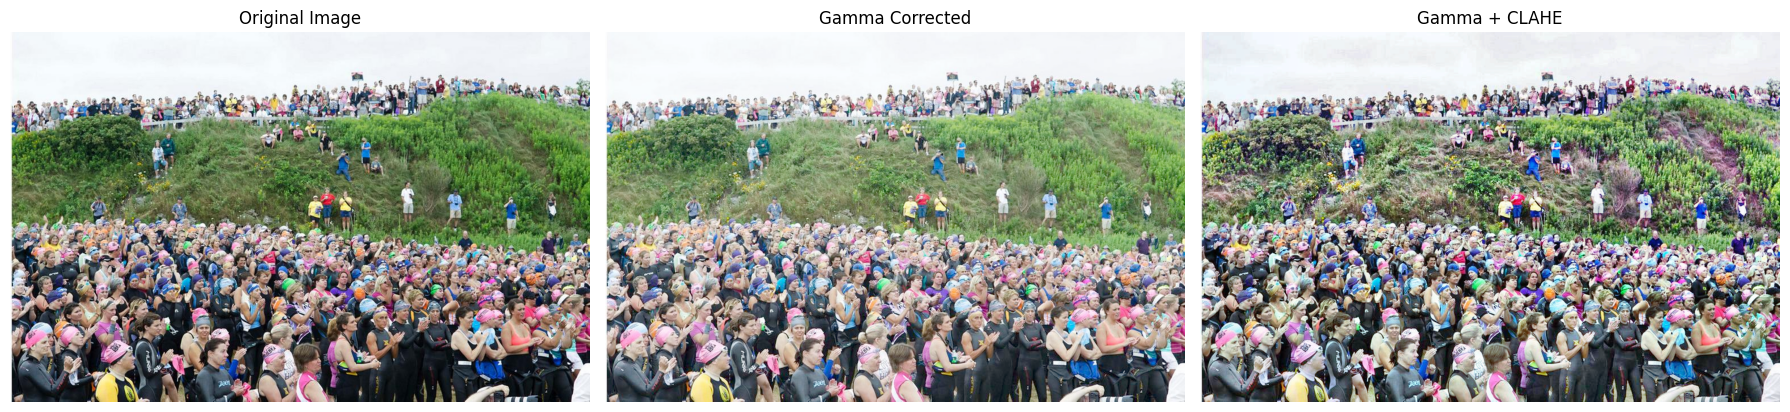

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# تحميل الصورة الأصلية
image_path = "/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images/IMG_100.jpg"  # غيّر المسار حسب بياناتك
original_image = Image.open(image_path).convert('RGB')
original_np = np.array(original_image)

# تحويل الصورة إلى BGR لاستخدام OpenCV
bgr_image = cv2.cvtColor(original_np, cv2.COLOR_RGB2BGR)

# 1. تصحيح غاما فقط
def apply_gamma(np_image, gamma=1.5):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(np_image, table)

gamma_image = apply_gamma(bgr_image)

# 2. CLAHE بعد تصحيح غاما
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
channels = cv2.split(gamma_image)
clahe_channels = [clahe.apply(c) for c in channels]
final_image = cv2.merge(clahe_channels)

# تحويل الصور من BGR إلى RGB للعرض
original_rgb = original_np
gamma_rgb = cv2.cvtColor(gamma_image, cv2.COLOR_BGR2RGB)
final_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

# عرض الثلاث صور جنبًا إلى جنب
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gamma_rgb)
plt.title("Gamma Corrected")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(final_rgb)
plt.title("Gamma + CLAHE")
plt.axis("off")

plt.tight_layout()
plt.show()


In [13]:
from torch.utils.data import Dataset
import random
from PIL import Image
import torchvision.transforms as transforms
import torch

class ImageDataset(Dataset):  
    def __init__(self, json_data, transform=None, train=False, batch_size=1, num_workers=4, image_size=(224, 224), label_size=(50,)):  
        random.shuffle(json_data)
        self.dataset_size = len(json_data)  
        self.data_entries = json_data       
        self.transform = transform
        self.train = train
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.image_size = image_size  # Ensure all images are resized
        self.label_size = label_size  # Standardize label size

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, index):
        assert index < len(self), 'Index out of range' 
        image_path = self.data_entries[index]  
        
        # Load image and label
        image, label = load_and_preprocess_data(image_path, self.train)

        # Ensure image is in PIL format before applying transforms
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)

        # Resize image to fixed size
        resize_transform = transforms.Resize(self.image_size)
        image = resize_transform(image)

        # Apply additional transformations
        if self.transform is not None:
            image = self.transform(image)

        # Convert label to a fixed shape (Padding or Truncating)
        label = torch.tensor(label, dtype=torch.float32)  # Convert to tensor
        if label.numel() < self.label_size[0]:  # Pad if label is too small
            padding = torch.zeros(self.label_size[0] - label.numel())
            label = torch.cat((label, padding))
        else:  # Truncate if label is too large
            label = label[:self.label_size[0]]

        return image, label


In [14]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')     

In [15]:
from torch.nn.functional import sigmoid as F_sigmoid
class ContextualModule(nn.Module):
    def __init__(self, features, out_features=512, sizes=(1, 2, 3, 6)):
        super(ContextualModule, self).__init__()
        self.scales = nn.ModuleList([self._make_scale(features, size) for size in sizes])
        self.bottleneck = nn.Conv2d(features * 2, out_features, kernel_size=1)
        self.relu = nn.ReLU()
        self.weight_net = nn.Conv2d(features,features,kernel_size=1)

    def __make_weight(self, feature, scale_feature):
        weight_feature = feature - scale_feature
        return F_sigmoid(self.weight_net(weight_feature))

    def _make_scale(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        multi_scales = [interpolate(input=stage(feats), size=(h, w), mode='bilinear') for stage in self.scales]
        weights = [self.__make_weight(feats,scale_feature) for scale_feature in multi_scales]
        weighted_sum = sum(m * w for m, w in zip(multi_scales, weights))
        weight_sum = sum(weights)
        overall_features = [weighted_sum / weight_sum] + [feats]
        bottle = self.bottleneck(torch.cat(overall_features, 1))
        return self.relu(bottle)

In [16]:
selected_model = models.vgg16(weights='DEFAULT')
frontend = nn.Sequential(*list(selected_model.children())[0][:23])

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 239MB/s] 


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAndSpatial_Block(nn.Module):
    def __init__(self, c, r=16):
        super(ChannelAndSpatial_Block, self).__init__()
        
        # Channel Attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.channel_mlp = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False)
        )
        self.sigmoid_channel = nn.Sigmoid()

        # Spatial Attention
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()

        # --- Channel Attention ---
        avg_out = self.avg_pool(x).view(batch_size, num_channels)
        max_out = self.max_pool(x).view(batch_size, num_channels)

        avg_out = self.channel_mlp(avg_out)
        max_out = self.channel_mlp(max_out)

        channel_attention = self.sigmoid_channel(avg_out + max_out).view(batch_size, num_channels, 1, 1)
        x = x * channel_attention.expand_as(x)

        # --- Spatial Attention ---
        avg_channel = torch.mean(x, dim=1, keepdim=True)
        max_channel, _ = torch.max(x, dim=1, keepdim=True)
        spatial_input = torch.cat([avg_channel, max_channel], dim=1)

        spatial_attention = self.sigmoid_spatial(self.conv_spatial(spatial_input))
        x = x * spatial_attention.expand_as(x)

        return x


In [18]:
!pip install segmentation_models_pytorch

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

# ---------- Channel + Spatial Attention Block ----------
class ChannelAndSpatial_Block(nn.Module):
    def __init__(self, c, r=16):
        super(ChannelAndSpatial_Block, self).__init__()
        
        # Channel Attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.channel_mlp = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False)
        )
        self.sigmoid_channel = nn.Sigmoid()

        # Spatial Attention
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()

        # --- Channel Attention ---
        avg_out = self.avg_pool(x).view(batch_size, num_channels)
        max_out = self.max_pool(x).view(batch_size, num_channels)

        avg_out = self.channel_mlp(avg_out)
        max_out = self.channel_mlp(max_out)

        channel_attention = self.sigmoid_channel(avg_out + max_out).view(batch_size, num_channels, 1, 1)
        x = x * channel_attention.expand_as(x)

        # --- Spatial Attention ---
        avg_channel = torch.mean(x, dim=1, keepdim=True)
        max_channel, _ = torch.max(x, dim=1, keepdim=True)
        spatial_input = torch.cat([avg_channel, max_channel], dim=1)

        spatial_attention = self.sigmoid_spatial(self.conv_spatial(spatial_input))
        x = x * spatial_attention.expand_as(x)

        return x

# ---------- Main Network ----------
class CANNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CANNet, self).__init__()
        self.unet = smp.Unet(
            encoder_name="resnet18",
            encoder_weights="imagenet",
            encoder_depth=3,
            in_channels=3,
            classes=1,
            decoder_channels=[3,3,3]
        )
        self.frontend = frontend  # ⚠️ تأكد من أن هذا معرّف مسبقًا
        self.n_feature_maps = 512
        self.context = ContextualModule(self.n_feature_maps + 128, self.n_feature_maps)
        self.backend_structure = [512, 512, 512, 256, 128, 64]
        self.backend = create_layers(self.backend_structure, input_channels=512, use_batch_norm=True, use_dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

        # ✅ استبدال SE بـ Channel + Spatial Attention
        self.attention_block = ChannelAndSpatial_Block(c=self.n_feature_maps + 128)

    def forward(self, x):
        unet_features = self.unet.encoder(x)[-1]  # استخدم آخر طبقة encoder فقط
        frontend_features = self.frontend(x)
        combined_features = torch.cat([frontend_features, unet_features], dim=1)
        x = self.attention_block(combined_features)  # ✅ استبدال se_block
        x = self.context(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

# ---------- Backend Layers Builder ----------
def create_layers(architecture, input_channels=512, use_batch_norm=False, use_dilation=False):
    network_layers = []
    current_channels = input_channels
    dilation_size = 2 if use_dilation else 1

    for output_channels in architecture:
        conv_layer = nn.Conv2d(
            current_channels, 
            output_channels, 
            kernel_size=3, 
            padding=dilation_size, 
            dilation=dilation_size
        )
        nn.init.normal_(conv_layer.weight, std=0.01)
        nn.init.constant_(conv_layer.bias, 0)

        if use_batch_norm:
            norm_layer = nn.BatchNorm2d(output_channels)
            nn.init.constant_(norm_layer.weight, 1)
            nn.init.constant_(norm_layer.bias, 0)
            network_layers += [conv_layer, norm_layer, nn.ReLU(inplace=True)]
        else:
            network_layers += [conv_layer, nn.ReLU(inplace=True)]

        current_channels = output_channels

    return nn.Sequential(*network_layers)


In [20]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Function to pad ground truth labels to the max size in the batch
def collate_fn(batch):
    images, labels = zip(*batch)  # Unpack images and labels

    # Stack images (assuming they are already resized)
    images = torch.stack(images, dim=0)

    # Find max label size in batch
    max_h = max(label.shape[0] for label in labels)
    max_w = max(label.shape[1] for label in labels)

    # Pad labels
    padded_labels = []
    for label in labels:
        pad_h = max_h - label.shape[0]
        pad_w = max_w - label.shape[1]
        padded_label = torch.nn.functional.pad(label, (0, pad_w, 0, pad_h), value=0)
        padded_labels.append(padded_label)

    labels = torch.stack(padded_labels, dim=0)

    return images, labels

# Training function
def train(training_data, model, optimizer, current_epoch, batch_size=8, workers=4, lr=1e-3, print_freq=10):
    # Create DataLoader
    data_loader = DataLoader(
        ImageDataset(training_data,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225]),
                     ]),
                     train=True),
        batch_size=batch_size,
        num_workers=workers,
        shuffle=True,
        collate_fn=collate_fn  # Handle variable-sized labels
    )

    print(f"Epoch {current_epoch} | Training Samples: {len(data_loader.dataset)} | Learning Rate: {lr:.6f}")

    # Set model to training mode
    model.train()

    # Initialize loss accumulators
    total_loss = 0
    mse_loss_total = 0
    mae_loss_total = 0
    huber_loss_total = 0

    # Define multiple loss functions
    mse_loss_fn = nn.MSELoss(reduction='mean').cuda()
    mae_loss_fn = nn.L1Loss(reduction='mean').cuda()
    huber_loss_fn = nn.SmoothL1Loss(beta=1.0, reduction='mean').cuda()

    # Training loop
    for batch_idx, (input_images, ground_truth) in enumerate(data_loader):
        input_images = input_images.cuda()
        ground_truth = ground_truth.cuda()

        # Forward pass
        predictions = model(input_images)[:, 0, :, :]

        # Resize predictions to match ground truth
        predictions = torch.nn.functional.interpolate(predictions.unsqueeze(1), 
                                                      size=ground_truth.shape[1:], 
                                                      mode='bilinear', align_corners=False).squeeze(1)

        # Compute losses
        mse_loss = mse_loss_fn(predictions, ground_truth)
        mae_loss = mae_loss_fn(predictions, ground_truth)
        huber_loss = huber_loss_fn(predictions, ground_truth)

        # Weighted sum of losses (adjust weights if needed)
        loss = mse_loss + mae_loss + 0.5 * huber_loss

        # Update loss accumulators
        total_loss += loss.item()
        mse_loss_total += mse_loss.item()
        mae_loss_total += mae_loss.item()
        huber_loss_total += huber_loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress at intervals
        if batch_idx % print_freq == 0:
            print(f"Epoch [{current_epoch}][{batch_idx}/{len(data_loader)}] | "
                  f"Loss: {loss.item():.4f} | MSE: {mse_loss.item():.4f} | "
                  f"MAE: {mae_loss.item():.4f} | Huber: {huber_loss.item():.4f}")

    # Compute average losses per epoch
    avg_total_loss = total_loss / len(data_loader)
    avg_mse_loss = mse_loss_total / len(data_loader)
    avg_mae_loss = mae_loss_total / len(data_loader)
    avg_huber_loss = huber_loss_total / len(data_loader)

    print(f"Epoch [{current_epoch}] Summary | Avg Loss: {avg_total_loss:.4f} | "
          f"MSE: {avg_mse_loss:.4f} | MAE: {avg_mae_loss:.4f} | Huber: {avg_huber_loss:.4f}")

    return avg_mse_loss, avg_mae_loss, avg_huber_loss, avg_total_loss


In [21]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from skimage.metrics import structural_similarity as ssim
import cv2

def validate(validation_data, model):
    """ Validate the model and compute evaluation metrics. """
    print("\n🔍 Begin Validation")

    # Define data loader
    data_loader = torch.utils.data.DataLoader(
        ImageDataset(validation_data,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]),
            ])), batch_size=1)

    model.eval()

    # Loss functions
    mse_loss_fn = nn.MSELoss(reduction='sum').cuda()
    mae_loss_fn = nn.L1Loss().cuda()
    huber_loss_fn = nn.SmoothL1Loss(beta=1.0).cuda()

    # Initialize accumulators
    total_mae, total_mse, total_huber = 0, 0, 0
    total_psnr, total_ssim = 0, 0
    total_samples = len(data_loader)

    # Initialize progress bar
    progress_bar = tqdm(total=total_samples, desc="Validating", position=0, leave=True)

    with torch.no_grad():
        for batch_idx, (input_images, ground_truth) in enumerate(data_loader):
            input_images = input_images.cuda()
            ground_truth = ground_truth.type(torch.FloatTensor).cuda()

            # Ensure ground truth has a channel dimension
            if ground_truth.dim() == 3:  # If shape is (N, H, W), add channel
                ground_truth = ground_truth.unsqueeze(1)  # (N, 1, H, W)

            # Get model prediction
            predicted_density = model(input_images)

            # Ensure predicted_density has a channel dimension
            if predicted_density.dim() == 3:
                predicted_density = predicted_density.unsqueeze(1)  # (N, 1, H, W)

            # Ensure the output shape matches the ground truth shape
            if predicted_density.shape != ground_truth.shape:
                predicted_density = torch.nn.functional.interpolate(
                    predicted_density, size=(ground_truth.shape[2], ground_truth.shape[3]), mode='bilinear', align_corners=False
                )

            # Squeeze channel dimension if necessary
            predicted_density = predicted_density.squeeze(1)  # (N, H, W)
            ground_truth = ground_truth.squeeze(1)

            # Compute losses
            mse = mse_loss_fn(predicted_density, ground_truth).item()
            mae = mae_loss_fn(predicted_density, ground_truth).item()
            huber = huber_loss_fn(predicted_density, ground_truth).item()

            # Convert to numpy for SSIM & PSNR computation
            pred_np = predicted_density.squeeze().cpu().numpy()
            gt_np = ground_truth.squeeze().cpu().numpy()

            # Resize prediction to ground truth size if needed
            if pred_np.shape != gt_np.shape:
                pred_resized = cv2.resize(pred_np, (gt_np.shape[1], gt_np.shape[0]), interpolation=cv2.INTER_CUBIC)
            else:
                pred_resized = pred_np

            # Compute SSIM and PSNR
            ssim_score = ssim(gt_np, pred_resized, data_range=gt_np.max() - gt_np.min())
            psnr_score = cv2.PSNR(gt_np, pred_resized)

            # Accumulate values
            total_mae += mae
            total_mse += mse
            total_huber += huber
            total_ssim += ssim_score
            total_psnr += psnr_score

            # Update tqdm progress bar
            progress_bar.update(1)
            progress_bar.set_postfix({
                "MAE": f"{mae:.4f}",
                "MSE": f"{mse:.4f}",
                "Huber": f"{huber:.4f}"
            })

    progress_bar.close()

    # Compute average metrics
    avg_mae = total_mae / total_samples
    avg_mse = total_mse / total_samples
    avg_huber = total_huber / total_samples
    avg_ssim = total_ssim / total_samples
    avg_psnr = total_psnr / total_samples

    print(f"\n✅ Validation Completed: "
          f"MAE: {avg_mae:.4f} | MSE: {avg_mse:.4f} | Huber: {avg_huber:.4f} "
          f"| SSIM: {avg_ssim:.4f} | PSNR: {avg_psnr:.4f}")

    return avg_mae, avg_mse, avg_huber, avg_ssim, avg_psnr


In [22]:
with open(saving_path + "train_imgs.json", 'r') as outfile:
    train_list = json.load(outfile)
with open(saving_path + "val_imgs.json", 'r') as outfile:
    val_list = json.load(outfile)

In [23]:
import torch.optim as optim


In [24]:
# **Hyperparameters**
best_prec1 = 1e6
lr = 1e-4
batch_size = 16  # Reduce this value if running out of memory
decay = 5 * 1e-4
start_epoch= 0
epochs =50
workers = 4
seed = int(time.time())
print_freq = 4
patience = 25  # Early stopping patience

torch.cuda.manual_seed(seed)

# **Model Initialization**
model = CANNet()
# checkpoint = torch.load('/kaggle/input/best/pytorch/default/1/model_best.pth.tar', weights_only=True)
# model.load_state_dict(checkpoint['state_dict'])
model = model.cuda()

# **Loss Functions**
mse_loss = nn.MSELoss(reduction='sum').cuda()
mae_loss = nn.L1Loss().cuda()  # Mean Absolute Error (MAE)
huber_loss = nn.SmoothL1Loss().cuda()  # Huber Loss for robust training

# **Optimizer & Learning Rate Scheduler**
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, factor=0.5, mode='min', verbose=True)

# **Tracking Training Loss**
train_mae_loss = []
train_mse_loss = []
train_huber_loss = []
train_total_loss = []

early_stop_counter = 0  # Early stopping counter
patience=25

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [25]:
for epoch in range(start_epoch, epochs):
    print(f"\n🔄 Training Epoch {epoch+1}/{epochs}...")

    # **Train the Model**
    train_mse, train_mae, train_huber, train_total = train(train_list, model, optimizer, epoch)

    # **Convert loss to float if necessary**
    train_mse = train_mse.item() if isinstance(train_mse, torch.Tensor) else train_mse
    train_mae = train_mae.item() if isinstance(train_mae, torch.Tensor) else train_mae
    train_huber = train_huber.item() if isinstance(train_huber, torch.Tensor) else train_huber
    train_total = train_total.item() if isinstance(train_total, torch.Tensor) else train_total

    # **Validate the Model**
    val_mae, val_mse, val_huber, val_ssim, val_psnr = validate(val_list, model)

    # **Check for Best Model**
    is_best = val_mae < best_prec1
    best_prec1 = min(val_mae, best_prec1)

    print(f"\n📊 Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {train_total:.3f} | "
          f"MAE: {val_mae:.3f} | MSE: {val_mse:.3f} | Huber: {val_huber:.3f} | "
          f"SSIM: {val_ssim:.3f} | PSNR: {val_psnr:.3f}")

    # **Track Losses**
    train_mae_loss.append(train_mae)
    train_mse_loss.append(train_mse)
    train_huber_loss.append(train_huber)
    train_total_loss.append(train_total)

    # **Adjust Learning Rate**
    scheduler.step(val_mae)

    # **Save Best Model Checkpoint**
    if is_best:
        early_stop_counter = 0
        save_checkpoint({'state_dict': model.state_dict()}, is_best)
    else:
        early_stop_counter += 1
        print(f"⏳ No improvement for {early_stop_counter} epochs.")

    # **Early Stopping**
    if early_stop_counter >= patience:
        print("🚀 Early stopping triggered. Training stopped.")
        break

print("\n🎯 Best MAE:", best_prec1)



🔄 Training Epoch 1/50...
Epoch 0 | Training Samples: 240 | Learning Rate: 0.001000
Epoch [0][0/30] | Loss: 0.5907 | MSE: 0.1887 | MAE: 0.3556 | Huber: 0.0930
Epoch [0][10/30] | Loss: 0.2128 | MSE: 0.0597 | MAE: 0.1389 | Huber: 0.0285
Epoch [0][20/30] | Loss: 0.0736 | MSE: 0.0188 | MAE: 0.0503 | Huber: 0.0090
Epoch [0] Summary | Avg Loss: 0.1951 | MSE: 0.0523 | MAE: 0.1300 | Huber: 0.0256

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 40.93it/s, MAE=0.0963, MSE=117.3267, Huber=0.0092] 



✅ Validation Completed: MAE: 0.1093 | MSE: 207.4822 | Huber: 0.0174 | SSIM: 0.0128 | PSNR: 66.2261

📊 Epoch [1/50] | Train Loss: 0.195 | MAE: 0.109 | MSE: 207.482 | Huber: 0.017 | SSIM: 0.013 | PSNR: 66.226

🔄 Training Epoch 2/50...
Epoch 1 | Training Samples: 240 | Learning Rate: 0.001000
Epoch [1][0/30] | Loss: 0.0248 | MSE: 0.0014 | MAE: 0.0230 | Huber: 0.0007
Epoch [1][10/30] | Loss: 0.0692 | MSE: 0.0113 | MAE: 0.0550 | Huber: 0.0057
Epoch [1][20/30] | Loss: 0.0947 | MSE: 0.0296 | MAE: 0.0580 | Huber: 0.0141
Epoch [1] Summary | Avg Loss: 0.0603 | MSE: 0.0109 | MAE: 0.0466 | Huber: 0.0054

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 39.76it/s, MAE=0.0554, MSE=30.1636, Huber=0.0024]  



✅ Validation Completed: MAE: 0.0757 | MSE: 147.8155 | Huber: 0.0116 | SSIM: 0.1381 | PSNR: 69.1573

📊 Epoch [2/50] | Train Loss: 0.060 | MAE: 0.076 | MSE: 147.815 | Huber: 0.012 | SSIM: 0.138 | PSNR: 69.157

🔄 Training Epoch 3/50...
Epoch 2 | Training Samples: 240 | Learning Rate: 0.001000
Epoch [2][0/30] | Loss: 0.0302 | MSE: 0.0017 | MAE: 0.0282 | Huber: 0.0008
Epoch [2][10/30] | Loss: 0.0484 | MSE: 0.0086 | MAE: 0.0377 | Huber: 0.0043
Epoch [2][20/30] | Loss: 0.0448 | MSE: 0.0047 | MAE: 0.0388 | Huber: 0.0024
Epoch [2] Summary | Avg Loss: 0.0530 | MSE: 0.0088 | MAE: 0.0421 | Huber: 0.0043

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 40.86it/s, MAE=0.0556, MSE=43.2590, Huber=0.0034]  


✅ Validation Completed: MAE: 0.1106 | MSE: 206.8334 | Huber: 0.0162 | SSIM: 0.1126 | PSNR: 65.2824

📊 Epoch [3/50] | Train Loss: 0.053 | MAE: 0.111 | MSE: 206.833 | Huber: 0.016 | SSIM: 0.113 | PSNR: 65.282
⏳ No improvement for 1 epochs.

🔄 Training Epoch 4/50...
Epoch 3 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [3][0/30] | Loss: 0.0477 | MSE: 0.0039 | MAE: 0.0429 | Huber: 0.0020
Epoch [3][10/30] | Loss: 0.0324 | MSE: 0.0027 | MAE: 0.0291 | Huber: 0.0013
Epoch [3][20/30] | Loss: 0.0538 | MSE: 0.0070 | MAE: 0.0451 | Huber: 0.0035
Epoch [3] Summary | Avg Loss: 0.0540 | MSE: 0.0093 | MAE: 0.0424 | Huber: 0.0046

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.16it/s, MAE=0.1097, MSE=223.5631, Huber=0.0170] 


✅ Validation Completed: MAE: 0.1031 | MSE: 198.6315 | Huber: 0.0155 | SSIM: 0.0943 | PSNR: 66.3325

📊 Epoch [4/50] | Train Loss: 0.054 | MAE: 0.103 | MSE: 198.631 | Huber: 0.016 | SSIM: 0.094 | PSNR: 66.333
⏳ No improvement for 2 epochs.

🔄 Training Epoch 5/50...
Epoch 4 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [4][0/30] | Loss: 0.0308 | MSE: 0.0029 | MAE: 0.0271 | Huber: 0.0015
Epoch [4][10/30] | Loss: 0.0461 | MSE: 0.0073 | MAE: 0.0370 | Huber: 0.0037
Epoch [4][20/30] | Loss: 0.0371 | MSE: 0.0048 | MAE: 0.0311 | Huber: 0.0024
Epoch [4] Summary | Avg Loss: 0.0508 | MSE: 0.0086 | MAE: 0.0401 | Huber: 0.0042

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.80it/s, MAE=0.1204, MSE=171.8434, Huber=0.0134] 


✅ Validation Completed: MAE: 0.0981 | MSE: 186.7614 | Huber: 0.0145 | SSIM: 0.1480 | PSNR: 66.3550

📊 Epoch [5/50] | Train Loss: 0.051 | MAE: 0.098 | MSE: 186.761 | Huber: 0.015 | SSIM: 0.148 | PSNR: 66.355
⏳ No improvement for 3 epochs.

🔄 Training Epoch 6/50...
Epoch 5 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [5][0/30] | Loss: 0.0321 | MSE: 0.0025 | MAE: 0.0290 | Huber: 0.0012
Epoch [5][10/30] | Loss: 0.0328 | MSE: 0.0024 | MAE: 0.0298 | Huber: 0.0012
Epoch [5][20/30] | Loss: 0.0309 | MSE: 0.0034 | MAE: 0.0267 | Huber: 0.0017
Epoch [5] Summary | Avg Loss: 0.0523 | MSE: 0.0088 | MAE: 0.0413 | Huber: 0.0043

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.10it/s, MAE=0.0503, MSE=27.0568, Huber=0.0021]  



✅ Validation Completed: MAE: 0.0800 | MSE: 159.8071 | Huber: 0.0128 | SSIM: 0.1263 | PSNR: 68.8371

📊 Epoch [6/50] | Train Loss: 0.052 | MAE: 0.080 | MSE: 159.807 | Huber: 0.013 | SSIM: 0.126 | PSNR: 68.837
⏳ No improvement for 4 epochs.

🔄 Training Epoch 7/50...
Epoch 6 | Training Samples: 240 | Learning Rate: 0.001000
Epoch [6][0/30] | Loss: 0.0710 | MSE: 0.0121 | MAE: 0.0559 | Huber: 0.0060
Epoch [6][10/30] | Loss: 0.0394 | MSE: 0.0057 | MAE: 0.0323 | Huber: 0.0029
Epoch [6][20/30] | Loss: 0.0349 | MSE: 0.0032 | MAE: 0.0309 | Huber: 0.0016
Epoch [6] Summary | Avg Loss: 0.0445 | MSE: 0.0067 | MAE: 0.0361 | Huber: 0.0033

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.36it/s, MAE=0.0646, MSE=178.7586, Huber=0.0134] 



✅ Validation Completed: MAE: 0.0697 | MSE: 139.5605 | Huber: 0.0110 | SSIM: 0.1810 | PSNR: 70.1769

📊 Epoch [7/50] | Train Loss: 0.044 | MAE: 0.070 | MSE: 139.561 | Huber: 0.011 | SSIM: 0.181 | PSNR: 70.177

🔄 Training Epoch 8/50...
Epoch 7 | Training Samples: 240 | Learning Rate: 0.001000
Epoch [7][0/30] | Loss: 0.0326 | MSE: 0.0035 | MAE: 0.0281 | Huber: 0.0018
Epoch [7][10/30] | Loss: 0.0496 | MSE: 0.0057 | MAE: 0.0426 | Huber: 0.0028
Epoch [7][20/30] | Loss: 0.0803 | MSE: 0.0155 | MAE: 0.0609 | Huber: 0.0078
Epoch [7] Summary | Avg Loss: 0.0440 | MSE: 0.0067 | MAE: 0.0357 | Huber: 0.0033

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 40.18it/s, MAE=0.0341, MSE=12.8318, Huber=0.0010]  


✅ Validation Completed: MAE: 0.0956 | MSE: 206.4104 | Huber: 0.0164 | SSIM: 0.1462 | PSNR: 67.5172

📊 Epoch [8/50] | Train Loss: 0.044 | MAE: 0.096 | MSE: 206.410 | Huber: 0.016 | SSIM: 0.146 | PSNR: 67.517
⏳ No improvement for 1 epochs.

🔄 Training Epoch 9/50...
Epoch 8 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [8][0/30] | Loss: 0.0459 | MSE: 0.0066 | MAE: 0.0376 | Huber: 0.0033
Epoch [8][10/30] | Loss: 0.0428 | MSE: 0.0037 | MAE: 0.0382 | Huber: 0.0018
Epoch [8][20/30] | Loss: 0.0368 | MSE: 0.0038 | MAE: 0.0321 | Huber: 0.0019
Epoch [8] Summary | Avg Loss: 0.0476 | MSE: 0.0081 | MAE: 0.0376 | Huber: 0.0040

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.35it/s, MAE=0.0467, MSE=24.4735, Huber=0.0028]  


✅ Validation Completed: MAE: 0.1260 | MSE: 303.4067 | Huber: 0.0242 | SSIM: 0.1491 | PSNR: 64.7301

📊 Epoch [9/50] | Train Loss: 0.048 | MAE: 0.126 | MSE: 303.407 | Huber: 0.024 | SSIM: 0.149 | PSNR: 64.730
⏳ No improvement for 2 epochs.

🔄 Training Epoch 10/50...
Epoch 9 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [9][0/30] | Loss: 0.0422 | MSE: 0.0041 | MAE: 0.0371 | Huber: 0.0020
Epoch [9][10/30] | Loss: 0.0268 | MSE: 0.0020 | MAE: 0.0244 | Huber: 0.0010
Epoch [9][20/30] | Loss: 0.1056 | MSE: 0.0237 | MAE: 0.0759 | Huber: 0.0119
Epoch [9] Summary | Avg Loss: 0.0467 | MSE: 0.0072 | MAE: 0.0378 | Huber: 0.0036

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 40.96it/s, MAE=0.0170, MSE=1.9837, Huber=0.0003]   



✅ Validation Completed: MAE: 0.0692 | MSE: 139.0619 | Huber: 0.0110 | SSIM: 0.1654 | PSNR: 70.7732

📊 Epoch [10/50] | Train Loss: 0.047 | MAE: 0.069 | MSE: 139.062 | Huber: 0.011 | SSIM: 0.165 | PSNR: 70.773

🔄 Training Epoch 11/50...
Epoch 10 | Training Samples: 240 | Learning Rate: 0.001000
Epoch [10][0/30] | Loss: 0.0555 | MSE: 0.0093 | MAE: 0.0439 | Huber: 0.0047
Epoch [10][10/30] | Loss: 0.0654 | MSE: 0.0189 | MAE: 0.0422 | Huber: 0.0085
Epoch [10][20/30] | Loss: 0.0425 | MSE: 0.0067 | MAE: 0.0342 | Huber: 0.0033
Epoch [10] Summary | Avg Loss: 0.0446 | MSE: 0.0075 | MAE: 0.0352 | Huber: 0.0037

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.91it/s, MAE=0.1403, MSE=185.6847, Huber=0.0158] 


✅ Validation Completed: MAE: 0.1114 | MSE: 262.1859 | Huber: 0.0206 | SSIM: 0.1556 | PSNR: 65.5776

📊 Epoch [11/50] | Train Loss: 0.045 | MAE: 0.111 | MSE: 262.186 | Huber: 0.021 | SSIM: 0.156 | PSNR: 65.578
⏳ No improvement for 1 epochs.

🔄 Training Epoch 12/50...
Epoch 11 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [11][0/30] | Loss: 0.0340 | MSE: 0.0037 | MAE: 0.0293 | Huber: 0.0019
Epoch [11][10/30] | Loss: 0.0363 | MSE: 0.0046 | MAE: 0.0305 | Huber: 0.0023
Epoch [11][20/30] | Loss: 0.0276 | MSE: 0.0026 | MAE: 0.0243 | Huber: 0.0013
Epoch [11] Summary | Avg Loss: 0.0480 | MSE: 0.0092 | MAE: 0.0366 | Huber: 0.0045

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.52it/s, MAE=0.0428, MSE=28.1802, Huber=0.0022]  


✅ Validation Completed: MAE: 0.0872 | MSE: 174.1846 | Huber: 0.0135 | SSIM: 0.1612 | PSNR: 68.0519

📊 Epoch [12/50] | Train Loss: 0.048 | MAE: 0.087 | MSE: 174.185 | Huber: 0.014 | SSIM: 0.161 | PSNR: 68.052
⏳ No improvement for 2 epochs.

🔄 Training Epoch 13/50...
Epoch 12 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [12][0/30] | Loss: 0.0271 | MSE: 0.0022 | MAE: 0.0244 | Huber: 0.0011
Epoch [12][10/30] | Loss: 0.0394 | MSE: 0.0064 | MAE: 0.0313 | Huber: 0.0032
Epoch [12][20/30] | Loss: 0.0635 | MSE: 0.0129 | MAE: 0.0474 | Huber: 0.0065
Epoch [12] Summary | Avg Loss: 0.0405 | MSE: 0.0061 | MAE: 0.0329 | Huber: 0.0030

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 40.85it/s, MAE=0.2307, MSE=652.5421, Huber=0.0510] 


✅ Validation Completed: MAE: 0.1102 | MSE: 255.9161 | Huber: 0.0201 | SSIM: 0.1488 | PSNR: 65.9390

📊 Epoch [13/50] | Train Loss: 0.040 | MAE: 0.110 | MSE: 255.916 | Huber: 0.020 | SSIM: 0.149 | PSNR: 65.939
⏳ No improvement for 3 epochs.

🔄 Training Epoch 14/50...
Epoch 13 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [13][0/30] | Loss: 0.0395 | MSE: 0.0045 | MAE: 0.0339 | Huber: 0.0022
Epoch [13][10/30] | Loss: 0.0248 | MSE: 0.0021 | MAE: 0.0222 | Huber: 0.0010
Epoch [13][20/30] | Loss: 0.0327 | MSE: 0.0033 | MAE: 0.0285 | Huber: 0.0016
Epoch [13] Summary | Avg Loss: 0.0415 | MSE: 0.0067 | MAE: 0.0332 | Huber: 0.0033

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.23it/s, MAE=0.0478, MSE=28.2459, Huber=0.0022]  


✅ Validation Completed: MAE: 0.1091 | MSE: 267.0668 | Huber: 0.0210 | SSIM: 0.1407 | PSNR: 66.3881

📊 Epoch [14/50] | Train Loss: 0.042 | MAE: 0.109 | MSE: 267.067 | Huber: 0.021 | SSIM: 0.141 | PSNR: 66.388
⏳ No improvement for 4 epochs.

🔄 Training Epoch 15/50...
Epoch 14 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [14][0/30] | Loss: 0.0465 | MSE: 0.0057 | MAE: 0.0394 | Huber: 0.0028
Epoch [14][10/30] | Loss: 0.0228 | MSE: 0.0017 | MAE: 0.0206 | Huber: 0.0008
Epoch [14][20/30] | Loss: 0.0702 | MSE: 0.0129 | MAE: 0.0541 | Huber: 0.0065
Epoch [14] Summary | Avg Loss: 0.0423 | MSE: 0.0066 | MAE: 0.0341 | Huber: 0.0033

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 40.92it/s, MAE=0.0452, MSE=20.4984, Huber=0.0016]  


✅ Validation Completed: MAE: 0.0739 | MSE: 144.2619 | Huber: 0.0113 | SSIM: 0.1437 | PSNR: 69.5789

📊 Epoch [15/50] | Train Loss: 0.042 | MAE: 0.074 | MSE: 144.262 | Huber: 0.011 | SSIM: 0.144 | PSNR: 69.579
⏳ No improvement for 5 epochs.

🔄 Training Epoch 16/50...
Epoch 15 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [15][0/30] | Loss: 0.0327 | MSE: 0.0040 | MAE: 0.0277 | Huber: 0.0020
Epoch [15][10/30] | Loss: 0.0332 | MSE: 0.0030 | MAE: 0.0294 | Huber: 0.0015
Epoch [15][20/30] | Loss: 0.0325 | MSE: 0.0040 | MAE: 0.0275 | Huber: 0.0020
Epoch [15] Summary | Avg Loss: 0.0414 | MSE: 0.0065 | MAE: 0.0334 | Huber: 0.0032

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 40.76it/s, MAE=0.3211, MSE=924.6087, Huber=0.0722] 



✅ Validation Completed: MAE: 0.1532 | MSE: 427.8322 | Huber: 0.0341 | SSIM: 0.1536 | PSNR: 63.0558

📊 Epoch [16/50] | Train Loss: 0.041 | MAE: 0.153 | MSE: 427.832 | Huber: 0.034 | SSIM: 0.154 | PSNR: 63.056
⏳ No improvement for 6 epochs.

🔄 Training Epoch 17/50...
Epoch 16 | Training Samples: 240 | Learning Rate: 0.001000
Epoch [16][0/30] | Loss: 0.0297 | MSE: 0.0027 | MAE: 0.0263 | Huber: 0.0013
Epoch [16][10/30] | Loss: 0.0523 | MSE: 0.0082 | MAE: 0.0421 | Huber: 0.0041
Epoch [16][20/30] | Loss: 0.0366 | MSE: 0.0026 | MAE: 0.0333 | Huber: 0.0013
Epoch [16] Summary | Avg Loss: 0.0416 | MSE: 0.0058 | MAE: 0.0344 | Huber: 0.0029

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.44it/s, MAE=0.0875, MSE=71.9991, Huber=0.0056]  


✅ Validation Completed: MAE: 0.0776 | MSE: 158.5024 | Huber: 0.0124 | SSIM: 0.1727 | PSNR: 69.3702

📊 Epoch [17/50] | Train Loss: 0.042 | MAE: 0.078 | MSE: 158.502 | Huber: 0.012 | SSIM: 0.173 | PSNR: 69.370
⏳ No improvement for 7 epochs.

🔄 Training Epoch 18/50...
Epoch 17 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [17][0/30] | Loss: 0.0563 | MSE: 0.0093 | MAE: 0.0446 | Huber: 0.0047
Epoch [17][10/30] | Loss: 0.0275 | MSE: 0.0021 | MAE: 0.0249 | Huber: 0.0010
Epoch [17][20/30] | Loss: 0.0438 | MSE: 0.0053 | MAE: 0.0372 | Huber: 0.0026
Epoch [17] Summary | Avg Loss: 0.0450 | MSE: 0.0077 | MAE: 0.0354 | Huber: 0.0038

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.17it/s, MAE=0.2387, MSE=853.8141, Huber=0.0683] 


✅ Validation Completed: MAE: 0.1333 | MSE: 416.6336 | Huber: 0.0326 | SSIM: 0.1779 | PSNR: 64.9408

📊 Epoch [18/50] | Train Loss: 0.045 | MAE: 0.133 | MSE: 416.634 | Huber: 0.033 | SSIM: 0.178 | PSNR: 64.941
⏳ No improvement for 8 epochs.

🔄 Training Epoch 19/50...
Epoch 18 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [18][0/30] | Loss: 0.0569 | MSE: 0.0130 | MAE: 0.0407 | Huber: 0.0065
Epoch [18][10/30] | Loss: 0.0193 | MSE: 0.0014 | MAE: 0.0176 | Huber: 0.0007
Epoch [18][20/30] | Loss: 0.0276 | MSE: 0.0027 | MAE: 0.0243 | Huber: 0.0014
Epoch [18] Summary | Avg Loss: 0.0390 | MSE: 0.0058 | MAE: 0.0317 | Huber: 0.0029

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 39.62it/s, MAE=0.0946, MSE=170.3191, Huber=0.0133] 


✅ Validation Completed: MAE: 0.1117 | MSE: 245.6143 | Huber: 0.0194 | SSIM: 0.1652 | PSNR: 65.7330

📊 Epoch [19/50] | Train Loss: 0.039 | MAE: 0.112 | MSE: 245.614 | Huber: 0.019 | SSIM: 0.165 | PSNR: 65.733
⏳ No improvement for 9 epochs.

🔄 Training Epoch 20/50...
Epoch 19 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [19][0/30] | Loss: 0.0515 | MSE: 0.0103 | MAE: 0.0387 | Huber: 0.0051
Epoch [19][10/30] | Loss: 0.0509 | MSE: 0.0082 | MAE: 0.0407 | Huber: 0.0041
Epoch [19][20/30] | Loss: 0.0268 | MSE: 0.0025 | MAE: 0.0237 | Huber: 0.0012
Epoch [19] Summary | Avg Loss: 0.0407 | MSE: 0.0067 | MAE: 0.0324 | Huber: 0.0033

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 39.55it/s, MAE=0.0858, MSE=82.2249, Huber=0.0064]  


✅ Validation Completed: MAE: 0.0913 | MSE: 172.4520 | Huber: 0.0134 | SSIM: 0.1306 | PSNR: 67.2023

📊 Epoch [20/50] | Train Loss: 0.041 | MAE: 0.091 | MSE: 172.452 | Huber: 0.013 | SSIM: 0.131 | PSNR: 67.202
⏳ No improvement for 10 epochs.

🔄 Training Epoch 21/50...
Epoch 20 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [20][0/30] | Loss: 0.0286 | MSE: 0.0027 | MAE: 0.0252 | Huber: 0.0013
Epoch [20][10/30] | Loss: 0.0236 | MSE: 0.0024 | MAE: 0.0206 | Huber: 0.0012
Epoch [20][20/30] | Loss: 0.0662 | MSE: 0.0173 | MAE: 0.0447 | Huber: 0.0083
Epoch [20] Summary | Avg Loss: 0.0376 | MSE: 0.0061 | MAE: 0.0300 | Huber: 0.0030

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 39.13it/s, MAE=0.1228, MSE=150.4832, Huber=0.0118] 


✅ Validation Completed: MAE: 0.1053 | MSE: 253.4476 | Huber: 0.0199 | SSIM: 0.1753 | PSNR: 66.6288

📊 Epoch [21/50] | Train Loss: 0.038 | MAE: 0.105 | MSE: 253.448 | Huber: 0.020 | SSIM: 0.175 | PSNR: 66.629
⏳ No improvement for 11 epochs.

🔄 Training Epoch 22/50...
Epoch 21 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [21][0/30] | Loss: 0.0310 | MSE: 0.0035 | MAE: 0.0266 | Huber: 0.0017
Epoch [21][10/30] | Loss: 0.0507 | MSE: 0.0056 | MAE: 0.0437 | Huber: 0.0028
Epoch [21][20/30] | Loss: 0.0406 | MSE: 0.0050 | MAE: 0.0343 | Huber: 0.0025
Epoch [21] Summary | Avg Loss: 0.0379 | MSE: 0.0058 | MAE: 0.0307 | Huber: 0.0028

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.08it/s, MAE=0.0569, MSE=44.3654, Huber=0.0035]  


✅ Validation Completed: MAE: 0.1096 | MSE: 235.9643 | Huber: 0.0187 | SSIM: 0.0886 | PSNR: 66.3792

📊 Epoch [22/50] | Train Loss: 0.038 | MAE: 0.110 | MSE: 235.964 | Huber: 0.019 | SSIM: 0.089 | PSNR: 66.379
⏳ No improvement for 12 epochs.

🔄 Training Epoch 23/50...
Epoch 22 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [22][0/30] | Loss: 0.0713 | MSE: 0.0187 | MAE: 0.0482 | Huber: 0.0089
Epoch [22][10/30] | Loss: 0.0347 | MSE: 0.0031 | MAE: 0.0308 | Huber: 0.0015
Epoch [22][20/30] | Loss: 0.0407 | MSE: 0.0061 | MAE: 0.0331 | Huber: 0.0031
Epoch [22] Summary | Avg Loss: 0.0381 | MSE: 0.0061 | MAE: 0.0305 | Huber: 0.0030

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 40.16it/s, MAE=0.0442, MSE=14.2253, Huber=0.0017]  


✅ Validation Completed: MAE: 0.1263 | MSE: 312.9120 | Huber: 0.0245 | SSIM: 0.1630 | PSNR: 65.0023

📊 Epoch [23/50] | Train Loss: 0.038 | MAE: 0.126 | MSE: 312.912 | Huber: 0.025 | SSIM: 0.163 | PSNR: 65.002
⏳ No improvement for 13 epochs.

🔄 Training Epoch 24/50...
Epoch 23 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [23][0/30] | Loss: 0.0227 | MSE: 0.0018 | MAE: 0.0205 | Huber: 0.0009
Epoch [23][10/30] | Loss: 0.0300 | MSE: 0.0024 | MAE: 0.0271 | Huber: 0.0012
Epoch [23][20/30] | Loss: 0.0337 | MSE: 0.0040 | MAE: 0.0286 | Huber: 0.0020
Epoch [23] Summary | Avg Loss: 0.0382 | MSE: 0.0057 | MAE: 0.0311 | Huber: 0.0028

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 40.19it/s, MAE=0.0248, MSE=4.8980, Huber=0.0006]   


✅ Validation Completed: MAE: 0.0830 | MSE: 164.9106 | Huber: 0.0129 | SSIM: 0.1898 | PSNR: 68.3590

📊 Epoch [24/50] | Train Loss: 0.038 | MAE: 0.083 | MSE: 164.911 | Huber: 0.013 | SSIM: 0.190 | PSNR: 68.359
⏳ No improvement for 14 epochs.

🔄 Training Epoch 25/50...
Epoch 24 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [24][0/30] | Loss: 0.0277 | MSE: 0.0026 | MAE: 0.0244 | Huber: 0.0013
Epoch [24][10/30] | Loss: 0.0359 | MSE: 0.0049 | MAE: 0.0298 | Huber: 0.0024
Epoch [24][20/30] | Loss: 0.0445 | MSE: 0.0083 | MAE: 0.0341 | Huber: 0.0041
Epoch [24] Summary | Avg Loss: 0.0487 | MSE: 0.0093 | MAE: 0.0371 | Huber: 0.0045

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 40.58it/s, MAE=0.3558, MSE=2732.7568, Huber=0.1851]


✅ Validation Completed: MAE: 0.1901 | MSE: 891.6936 | Huber: 0.0686 | SSIM: 0.1405 | PSNR: 62.0320

📊 Epoch [25/50] | Train Loss: 0.049 | MAE: 0.190 | MSE: 891.694 | Huber: 0.069 | SSIM: 0.140 | PSNR: 62.032
⏳ No improvement for 15 epochs.

🔄 Training Epoch 26/50...
Epoch 25 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [25][0/30] | Loss: 0.0713 | MSE: 0.0156 | MAE: 0.0518 | Huber: 0.0078
Epoch [25][10/30] | Loss: 0.0727 | MSE: 0.0166 | MAE: 0.0519 | Huber: 0.0083
Epoch [25][20/30] | Loss: 0.0270 | MSE: 0.0026 | MAE: 0.0238 | Huber: 0.0013
Epoch [25] Summary | Avg Loss: 0.0409 | MSE: 0.0066 | MAE: 0.0326 | Huber: 0.0033

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.77it/s, MAE=0.0178, MSE=3.5473, Huber=0.0005]   



✅ Validation Completed: MAE: 0.0818 | MSE: 179.7508 | Huber: 0.0142 | SSIM: 0.2033 | PSNR: 69.0972

📊 Epoch [26/50] | Train Loss: 0.041 | MAE: 0.082 | MSE: 179.751 | Huber: 0.014 | SSIM: 0.203 | PSNR: 69.097
⏳ No improvement for 16 epochs.

🔄 Training Epoch 27/50...
Epoch 26 | Training Samples: 240 | Learning Rate: 0.001000
Epoch [26][0/30] | Loss: 0.0208 | MSE: 0.0015 | MAE: 0.0189 | Huber: 0.0007
Epoch [26][10/30] | Loss: 0.0314 | MSE: 0.0030 | MAE: 0.0276 | Huber: 0.0015
Epoch [26][20/30] | Loss: 0.0292 | MSE: 0.0026 | MAE: 0.0259 | Huber: 0.0013
Epoch [26] Summary | Avg Loss: 0.0430 | MSE: 0.0078 | MAE: 0.0332 | Huber: 0.0039

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.20it/s, MAE=0.1342, MSE=352.7023, Huber=0.0276] 


✅ Validation Completed: MAE: 0.0921 | MSE: 214.4506 | Huber: 0.0168 | SSIM: 0.1115 | PSNR: 67.8177

📊 Epoch [27/50] | Train Loss: 0.043 | MAE: 0.092 | MSE: 214.451 | Huber: 0.017 | SSIM: 0.112 | PSNR: 67.818
⏳ No improvement for 17 epochs.

🔄 Training Epoch 28/50...
Epoch 27 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [27][0/30] | Loss: 0.0336 | MSE: 0.0040 | MAE: 0.0287 | Huber: 0.0020
Epoch [27][10/30] | Loss: 0.0415 | MSE: 0.0044 | MAE: 0.0360 | Huber: 0.0022
Epoch [27][20/30] | Loss: 0.0307 | MSE: 0.0038 | MAE: 0.0260 | Huber: 0.0019
Epoch [27] Summary | Avg Loss: 0.0417 | MSE: 0.0061 | MAE: 0.0341 | Huber: 0.0030

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.10it/s, MAE=0.0438, MSE=10.2927, Huber=0.0016]  


✅ Validation Completed: MAE: 0.0873 | MSE: 182.3438 | Huber: 0.0145 | SSIM: 0.1711 | PSNR: 68.3656

📊 Epoch [28/50] | Train Loss: 0.042 | MAE: 0.087 | MSE: 182.344 | Huber: 0.014 | SSIM: 0.171 | PSNR: 68.366
⏳ No improvement for 18 epochs.

🔄 Training Epoch 29/50...
Epoch 28 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [28][0/30] | Loss: 0.0835 | MSE: 0.0207 | MAE: 0.0576 | Huber: 0.0104
Epoch [28][10/30] | Loss: 0.0332 | MSE: 0.0041 | MAE: 0.0281 | Huber: 0.0021
Epoch [28][20/30] | Loss: 0.0308 | MSE: 0.0025 | MAE: 0.0277 | Huber: 0.0013
Epoch [28] Summary | Avg Loss: 0.0447 | MSE: 0.0080 | MAE: 0.0348 | Huber: 0.0039

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 37.80it/s, MAE=0.0576, MSE=42.8746, Huber=0.0033]  


✅ Validation Completed: MAE: 0.0893 | MSE: 199.6080 | Huber: 0.0156 | SSIM: 0.2004 | PSNR: 68.2194

📊 Epoch [29/50] | Train Loss: 0.045 | MAE: 0.089 | MSE: 199.608 | Huber: 0.016 | SSIM: 0.200 | PSNR: 68.219
⏳ No improvement for 19 epochs.

🔄 Training Epoch 30/50...
Epoch 29 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [29][0/30] | Loss: 0.0211 | MSE: 0.0011 | MAE: 0.0197 | Huber: 0.0006
Epoch [29][10/30] | Loss: 0.0306 | MSE: 0.0026 | MAE: 0.0274 | Huber: 0.0013
Epoch [29][20/30] | Loss: 0.0276 | MSE: 0.0026 | MAE: 0.0244 | Huber: 0.0013
Epoch [29] Summary | Avg Loss: 0.0408 | MSE: 0.0065 | MAE: 0.0327 | Huber: 0.0032

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.41it/s, MAE=0.2370, MSE=604.6356, Huber=0.0472] 


✅ Validation Completed: MAE: 0.1171 | MSE: 287.5734 | Huber: 0.0225 | SSIM: 0.1814 | PSNR: 65.2355

📊 Epoch [30/50] | Train Loss: 0.041 | MAE: 0.117 | MSE: 287.573 | Huber: 0.022 | SSIM: 0.181 | PSNR: 65.235
⏳ No improvement for 20 epochs.

🔄 Training Epoch 31/50...
Epoch 30 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [30][0/30] | Loss: 0.0411 | MSE: 0.0042 | MAE: 0.0359 | Huber: 0.0021
Epoch [30][10/30] | Loss: 0.0204 | MSE: 0.0010 | MAE: 0.0191 | Huber: 0.0005
Epoch [30][20/30] | Loss: 0.0347 | MSE: 0.0048 | MAE: 0.0287 | Huber: 0.0024
Epoch [30] Summary | Avg Loss: 0.0422 | MSE: 0.0072 | MAE: 0.0333 | Huber: 0.0035

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 40.83it/s, MAE=0.0684, MSE=84.8656, Huber=0.0066]  


✅ Validation Completed: MAE: 0.0991 | MSE: 229.9858 | Huber: 0.0180 | SSIM: 0.1711 | PSNR: 67.0949

📊 Epoch [31/50] | Train Loss: 0.042 | MAE: 0.099 | MSE: 229.986 | Huber: 0.018 | SSIM: 0.171 | PSNR: 67.095
⏳ No improvement for 21 epochs.

🔄 Training Epoch 32/50...
Epoch 31 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [31][0/30] | Loss: 0.0250 | MSE: 0.0019 | MAE: 0.0227 | Huber: 0.0009
Epoch [31][10/30] | Loss: 0.0432 | MSE: 0.0063 | MAE: 0.0354 | Huber: 0.0031
Epoch [31][20/30] | Loss: 0.0496 | MSE: 0.0091 | MAE: 0.0383 | Huber: 0.0045
Epoch [31] Summary | Avg Loss: 0.0465 | MSE: 0.0081 | MAE: 0.0364 | Huber: 0.0040

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 40.50it/s, MAE=0.1830, MSE=276.2206, Huber=0.0216] 


✅ Validation Completed: MAE: 0.0954 | MSE: 178.0880 | Huber: 0.0139 | SSIM: 0.1728 | PSNR: 66.8103

📊 Epoch [32/50] | Train Loss: 0.047 | MAE: 0.095 | MSE: 178.088 | Huber: 0.014 | SSIM: 0.173 | PSNR: 66.810
⏳ No improvement for 22 epochs.

🔄 Training Epoch 33/50...
Epoch 32 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [32][0/30] | Loss: 0.0424 | MSE: 0.0059 | MAE: 0.0350 | Huber: 0.0030
Epoch [32][10/30] | Loss: 0.0426 | MSE: 0.0097 | MAE: 0.0305 | Huber: 0.0049
Epoch [32][20/30] | Loss: 0.0301 | MSE: 0.0031 | MAE: 0.0262 | Huber: 0.0015
Epoch [32] Summary | Avg Loss: 0.0426 | MSE: 0.0070 | MAE: 0.0339 | Huber: 0.0035

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 41.43it/s, MAE=0.1481, MSE=207.2643, Huber=0.0162] 



✅ Validation Completed: MAE: 0.1155 | MSE: 246.2880 | Huber: 0.0194 | SSIM: 0.1304 | PSNR: 65.0889

📊 Epoch [33/50] | Train Loss: 0.043 | MAE: 0.116 | MSE: 246.288 | Huber: 0.019 | SSIM: 0.130 | PSNR: 65.089
⏳ No improvement for 23 epochs.

🔄 Training Epoch 34/50...
Epoch 33 | Training Samples: 240 | Learning Rate: 0.001000
Epoch [33][0/30] | Loss: 0.0454 | MSE: 0.0070 | MAE: 0.0366 | Huber: 0.0035
Epoch [33][10/30] | Loss: 0.0384 | MSE: 0.0033 | MAE: 0.0342 | Huber: 0.0017
Epoch [33][20/30] | Loss: 0.0246 | MSE: 0.0018 | MAE: 0.0224 | Huber: 0.0009
Epoch [33] Summary | Avg Loss: 0.0420 | MSE: 0.0065 | MAE: 0.0338 | Huber: 0.0032

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 39.87it/s, MAE=0.2058, MSE=721.3309, Huber=0.0555] 


✅ Validation Completed: MAE: 0.0950 | MSE: 217.3752 | Huber: 0.0171 | SSIM: 0.1293 | PSNR: 67.6253

📊 Epoch [34/50] | Train Loss: 0.042 | MAE: 0.095 | MSE: 217.375 | Huber: 0.017 | SSIM: 0.129 | PSNR: 67.625
⏳ No improvement for 24 epochs.

🔄 Training Epoch 35/50...
Epoch 34 | Training Samples: 240 | Learning Rate: 0.001000


Epoch [34][0/30] | Loss: 0.0520 | MSE: 0.0080 | MAE: 0.0420 | Huber: 0.0040
Epoch [34][10/30] | Loss: 0.0310 | MSE: 0.0029 | MAE: 0.0274 | Huber: 0.0014
Epoch [34][20/30] | Loss: 0.0688 | MSE: 0.0176 | MAE: 0.0468 | Huber: 0.0088
Epoch [34] Summary | Avg Loss: 0.0411 | MSE: 0.0065 | MAE: 0.0329 | Huber: 0.0032

🔍 Begin Validation


Validating: 100%|██████████| 60/60 [00:01<00:00, 40.94it/s, MAE=0.3089, MSE=771.5195, Huber=0.1020] 



✅ Validation Completed: MAE: 0.1583 | MSE: 551.9340 | Huber: 0.0434 | SSIM: 0.1745 | PSNR: 62.9813

📊 Epoch [35/50] | Train Loss: 0.041 | MAE: 0.158 | MSE: 551.934 | Huber: 0.043 | SSIM: 0.174 | PSNR: 62.981
⏳ No improvement for 25 epochs.
🚀 Early stopping triggered. Training stopped.

🎯 Best MAE: 0.06917743769784769


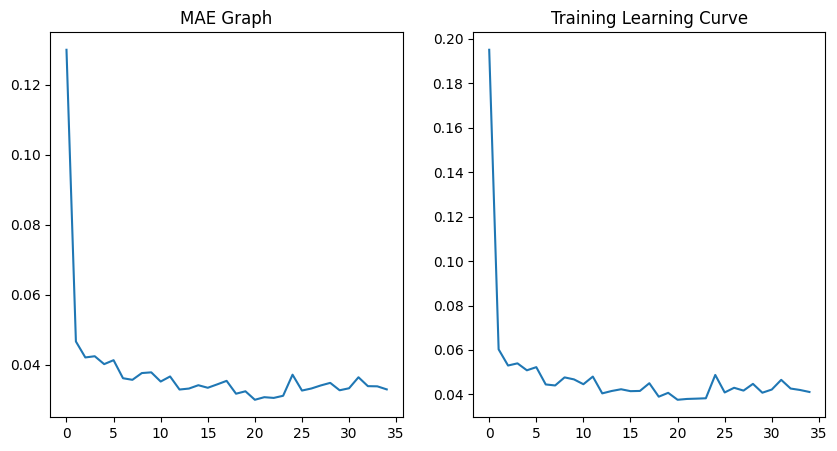

In [26]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("MAE Graph")
plt.plot(train_mae_loss)

plt.subplot(1,2,2)
plt.title("Training Learning Curve")
plt.plot(train_total_loss)
plt.show()

In [29]:
model_test = CANNet()
model_test = model_test.cuda()
checkpoint = torch.load('/kaggle/working/model_best.pth.tar', weights_only=True)
model_test.load_state_dict(checkpoint['state_dict'])  # verificare che funzioni
model_test.eval()
print("Loaded model")

Loaded model


In [92]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

transform=transforms.Compose([
   transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

img_folder = '/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/images/'
img_paths = []

for img_path in glob.glob(os.path.join(img_folder, '*.jpg')):
    img_paths.append(img_path)


In [93]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = []
ground_truths = []
similarity_scores = []

for idx in tqdm(range(len(img_paths))):
    input_image = transform(Image.open(img_paths[idx]).convert('RGB')).cuda()
    input_image = input_image.unsqueeze(0)

    height, width = input_image.shape[2:4]
    height_mid = height // 2
    width_mid = width // 2
    scaled_height = height // 8
    scaled_width = width // 8
    scaled_height_mid = scaled_height // 2
    scaled_width_mid = scaled_width // 2

    quadrant_1 = input_image[:, :, :height_mid, :width_mid]
    quadrant_2 = input_image[:, :, :height_mid, width_mid:]
    quadrant_3 = input_image[:, :, height_mid:, :width_mid]
    quadrant_4 = input_image[:, :, height_mid:, width_mid:]

    density_1 = model_test(quadrant_1).data.cpu().numpy()
    density_2 = model_test(quadrant_2).data.cpu().numpy()
    density_3 = model_test(quadrant_3).data.cpu().numpy()
    density_4 = model_test(quadrant_4).data.cpu().numpy()

    combined_density = np.zeros((scaled_height, scaled_width))
    combined_density[:scaled_height_mid, :scaled_width_mid] = density_1[0][0]
    combined_density[:scaled_height_mid, scaled_width_mid:] = density_2[0][0]
    combined_density[scaled_height_mid:, :scaled_width_mid] = density_3[0][0]
    combined_density[scaled_height_mid:, scaled_width_mid:] = density_4[0][0]

    dataset_split = img_paths[idx].split('/')[-3]
    image_filename = img_paths[idx].split('/')[-1]
    ground_truth_path = os.path.join(saving_path, dataset_split, image_filename.replace(".jpg", ".h5").replace("IMG_", "GT_IMG_"))

    if not os.path.exists(ground_truth_path):
        print(f"Ground truth file not found: {ground_truth_path}")
        continue

    with h5py.File(ground_truth_path, 'r') as ground_truth_file:
        ground_truth_map = np.asarray(ground_truth_file['density'])

    predicted_count = density_1.sum() + density_2.sum() + density_3.sum() + density_4.sum()
    resized_density = cv2.resize(combined_density, (width, height), interpolation=cv2.INTER_CUBIC)
    groundtruth_resized = cv2.resize(ground_truth_map, (scaled_width, scaled_height), interpolation=cv2.INTER_CUBIC) * 64
    similarity_score = ssim(combined_density, groundtruth_resized, data_range=groundtruth_resized.max() - groundtruth_resized.min())

    similarity_scores.append(similarity_score)
    predictions.append(predicted_count)
    ground_truths.append(np.sum(ground_truth_map))

# حساب المقاييس
mae = mean_absolute_error(predictions, ground_truths)
rmse = np.sqrt(mean_squared_error(predictions, ground_truths))
ssim_mean = np.mean(similarity_scores)

# طباعة النتائج
print("Benchmark Metrics (evaluated on test set)")
print("- MAE: ", mae)
print("- RMSE:", rmse)
print("Mean SSIM:", ssim_mean)


  1%|          | 3/316 [00:00<00:39,  7.97it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_233.h5


  2%|▏         | 5/316 [00:00<00:37,  8.19it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_289.h5


  3%|▎         | 8/316 [00:00<00:37,  8.25it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_190.h5


  4%|▍         | 12/316 [00:01<00:36,  8.31it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_266.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_212.h5


  5%|▌         | 17/316 [00:02<00:36,  8.23it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_236.h5


  6%|▌         | 19/316 [00:02<00:35,  8.39it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_315.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_228.h5


  7%|▋         | 22/316 [00:02<00:35,  8.37it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_200.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_237.h5


  8%|▊         | 25/316 [00:03<00:34,  8.37it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_313.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_188.h5


  9%|▊         | 27/316 [00:03<00:34,  8.34it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_283.h5


  9%|▉         | 30/316 [00:03<00:34,  8.33it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_247.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_204.h5


 11%|█         | 34/316 [00:04<00:33,  8.34it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_262.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_309.h5


 12%|█▏        | 37/316 [00:04<00:33,  8.28it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_241.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_249.h5


 12%|█▏        | 39/316 [00:04<00:33,  8.31it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_272.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_248.h5


 13%|█▎        | 41/316 [00:04<00:33,  8.33it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_277.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_274.h5


 14%|█▍        | 45/316 [00:05<00:33,  8.09it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_284.h5


 15%|█▍        | 47/316 [00:05<00:33,  8.07it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_276.h5


 16%|█▌        | 49/316 [00:05<00:32,  8.25it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_273.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_224.h5


 16%|█▌        | 51/316 [00:06<00:31,  8.28it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_234.h5


 17%|█▋        | 55/316 [00:06<00:31,  8.36it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_279.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_220.h5


 18%|█▊        | 58/316 [00:07<00:31,  8.32it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_295.h5


 19%|█▉        | 60/316 [00:07<00:30,  8.44it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_268.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_207.h5


 20%|██        | 64/316 [00:07<00:30,  8.37it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_243.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_192.h5


 21%|██        | 67/316 [00:08<00:30,  8.28it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_288.h5


 22%|██▏       | 69/316 [00:08<00:29,  8.31it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_219.h5


 23%|██▎       | 73/316 [00:08<00:29,  8.27it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_201.h5


 24%|██▍       | 76/316 [00:09<00:29,  8.18it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_184.h5


 26%|██▋       | 83/316 [00:10<00:28,  8.28it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_310.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_222.h5


 27%|██▋       | 85/316 [00:10<00:27,  8.28it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_252.h5


 28%|██▊       | 87/316 [00:10<00:27,  8.42it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_198.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_314.h5


 29%|██▉       | 92/316 [00:11<00:26,  8.39it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_213.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_185.h5


 30%|██▉       | 94/316 [00:11<00:26,  8.46it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_218.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_265.h5


 31%|███       | 97/316 [00:11<00:26,  8.30it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_231.h5


 32%|███▏      | 100/316 [00:12<00:26,  8.17it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_297.h5


 32%|███▏      | 102/316 [00:12<00:26,  8.13it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_285.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_183.h5


 34%|███▍      | 107/316 [00:12<00:26,  8.00it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_214.h5


 35%|███▌      | 111/316 [00:13<00:25,  8.02it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_304.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_196.h5


 36%|███▌      | 114/316 [00:13<00:24,  8.18it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_280.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_270.h5


 37%|███▋      | 117/316 [00:14<00:24,  8.25it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_244.h5


 38%|███▊      | 119/316 [00:14<00:23,  8.26it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_191.h5


 39%|███▉      | 124/316 [00:15<00:23,  8.20it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_306.h5


 40%|███▉      | 126/316 [00:15<00:22,  8.30it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_221.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_303.h5


 41%|████      | 128/316 [00:15<00:22,  8.23it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_230.h5


 41%|████      | 130/316 [00:15<00:22,  8.31it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_203.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_287.h5


 42%|████▏     | 132/316 [00:16<00:22,  8.28it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_216.h5


 42%|████▏     | 134/316 [00:16<00:21,  8.39it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_259.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_189.h5


 44%|████▍     | 139/316 [00:16<00:21,  8.17it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_225.h5


 45%|████▍     | 142/316 [00:17<00:20,  8.32it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_253.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_217.h5


 46%|████▌     | 144/316 [00:17<00:20,  8.29it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_208.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_197.h5


 47%|████▋     | 147/316 [00:17<00:20,  8.26it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_215.h5


 47%|████▋     | 149/316 [00:18<00:20,  8.29it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_255.h5


 48%|████▊     | 151/316 [00:18<00:19,  8.41it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_301.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_264.h5


 50%|████▉     | 157/316 [00:19<00:18,  8.37it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_278.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_296.h5


 54%|█████▍    | 171/316 [00:20<00:17,  8.24it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_275.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_261.h5


 55%|█████▌    | 174/316 [00:21<00:17,  8.27it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_229.h5


 57%|█████▋    | 181/316 [00:21<00:16,  8.16it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_286.h5


 58%|█████▊    | 183/316 [00:22<00:16,  8.17it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_316.h5


 59%|█████▉    | 186/316 [00:22<00:15,  8.26it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_205.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_269.h5


 59%|█████▉    | 188/316 [00:22<00:15,  8.27it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_307.h5


 60%|██████    | 191/316 [00:23<00:15,  8.17it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_282.h5


 61%|██████    | 193/316 [00:23<00:14,  8.30it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_260.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_302.h5


 63%|██████▎   | 199/316 [00:24<00:14,  8.27it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_263.h5


 64%|██████▍   | 203/316 [00:24<00:13,  8.26it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_258.h5


 66%|██████▋   | 210/316 [00:25<00:12,  8.23it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_186.h5


 67%|██████▋   | 212/316 [00:25<00:12,  8.25it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_226.h5


 68%|██████▊   | 214/316 [00:25<00:12,  8.38it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_293.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_256.h5


 68%|██████▊   | 216/316 [00:26<00:12,  8.31it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_305.h5


 69%|██████▉   | 218/316 [00:26<00:11,  8.27it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_223.h5


 70%|██████▉   | 220/316 [00:26<00:11,  8.39it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_312.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_292.h5


 70%|███████   | 222/316 [00:26<00:11,  8.36it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_238.h5


 71%|███████   | 225/316 [00:27<00:10,  8.39it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_206.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_254.h5


 72%|███████▏  | 229/316 [00:27<00:10,  8.25it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_242.h5


 74%|███████▍  | 234/316 [00:28<00:10,  8.12it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_195.h5


 75%|███████▌  | 237/316 [00:28<00:09,  8.21it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_298.h5


 77%|███████▋  | 243/316 [00:29<00:08,  8.16it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_257.h5


 78%|███████▊  | 248/316 [00:30<00:08,  8.08it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_300.h5


 81%|████████▏ | 257/316 [00:31<00:07,  8.20it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_227.h5


 82%|████████▏ | 259/316 [00:31<00:06,  8.36it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_235.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_290.h5


 85%|████████▍ | 268/316 [00:32<00:05,  8.05it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_251.h5


 86%|████████▋ | 273/316 [00:33<00:05,  8.09it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_199.h5


 87%|████████▋ | 276/316 [00:33<00:04,  8.27it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_271.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_250.h5


 88%|████████▊ | 278/316 [00:33<00:04,  8.26it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_299.h5


 89%|████████▊ | 280/316 [00:34<00:04,  8.38it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_291.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_194.h5


 90%|████████▉ | 283/316 [00:34<00:03,  8.42it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_209.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_308.h5


 91%|█████████ | 287/316 [00:34<00:03,  8.39it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_246.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_245.h5


 91%|█████████▏| 289/316 [00:35<00:03,  8.44it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_239.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_211.h5


 93%|█████████▎| 293/316 [00:35<00:02,  8.36it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_240.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_187.h5


 94%|█████████▎| 296/316 [00:35<00:02,  8.37it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_311.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_210.h5


 95%|█████████▍| 299/316 [00:36<00:02,  8.40it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_232.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_294.h5


 96%|█████████▌| 303/316 [00:36<00:01,  8.22it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_202.h5


 97%|█████████▋| 306/316 [00:37<00:01,  8.22it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_193.h5


 99%|█████████▊| 312/316 [00:37<00:00,  8.32it/s]

Ground truth file not found: /kaggle/working/test_data/GT_IMG_267.h5
Ground truth file not found: /kaggle/working/test_data/GT_IMG_281.h5


100%|██████████| 316/316 [00:38<00:00,  8.23it/s]

Benchmark Metrics (evaluated on test set)
- MAE:  307.4543721544874
- RMSE: 465.7997139874475
Mean SSIM: 0.18895775611690288


In [78]:
print("Benchmark Metrics (evaluated on test set)")
print('- MAE: ',mae)
print('- RMSE: ',rmse)
print("Mean SSIM: ", ssim_mean)

Benchmark Metrics (evaluated on test set)
- MAE:  307.4543721544874
- RMSE:  465.7997139874475
Mean SSIM:  0.18895775611690288


In [99]:
index_test = 121
img_real = Image.open(img_paths[index_test])
img_test = transform(Image.open(img_paths[index_test]).convert('RGB')).cuda()
img_test = img_test.unsqueeze(0)
h,w = img_test.shape[2:4]
h_d = int(h/2)
w_d = int(w/2)
img_1 = img_test[:,:,:h_d,:w_d].cuda()
img_2 = img_test[:,:,:h_d,w_d:].cuda()
img_3 = img_test[:,:,h_d:,:w_d].cuda()
img_4 = img_test[:,:,h_d:,w_d:].cuda()
density_1 = model_test(img_1).data.cpu().numpy()
density_2 = model_test(img_2).data.cpu().numpy()
density_3 = model_test(img_3).data.cpu().numpy()
density_4 = model_test(img_4).data.cpu().numpy()

gt_filepath = os.path.join(saving_path, img_paths[index_test].split('/')[-3], img_paths[index_test].split('/')[-1].replace(".jpg", ".h5").replace("IMG_", "GT_IMG_"))
gt_file = h5py.File(gt_filepath,'r')
groundtruth = np.asarray(gt_file['density'])
pred_sum = density_1.sum()+density_2.sum()+density_3.sum()+density_4.sum()
pred_sum, sum(sum(groundtruth))



(145.45749, 213.9999999999999)

In [100]:
img_test = img_test.squeeze()  # This will remove any dimensions with size 1
img_test = img_test.permute(1, 2, 0)  # Change the shape to (768, 1024, 3)
img_test = img_test.cpu().numpy()

SSIM tra density_map e groundtruth: 0.3457


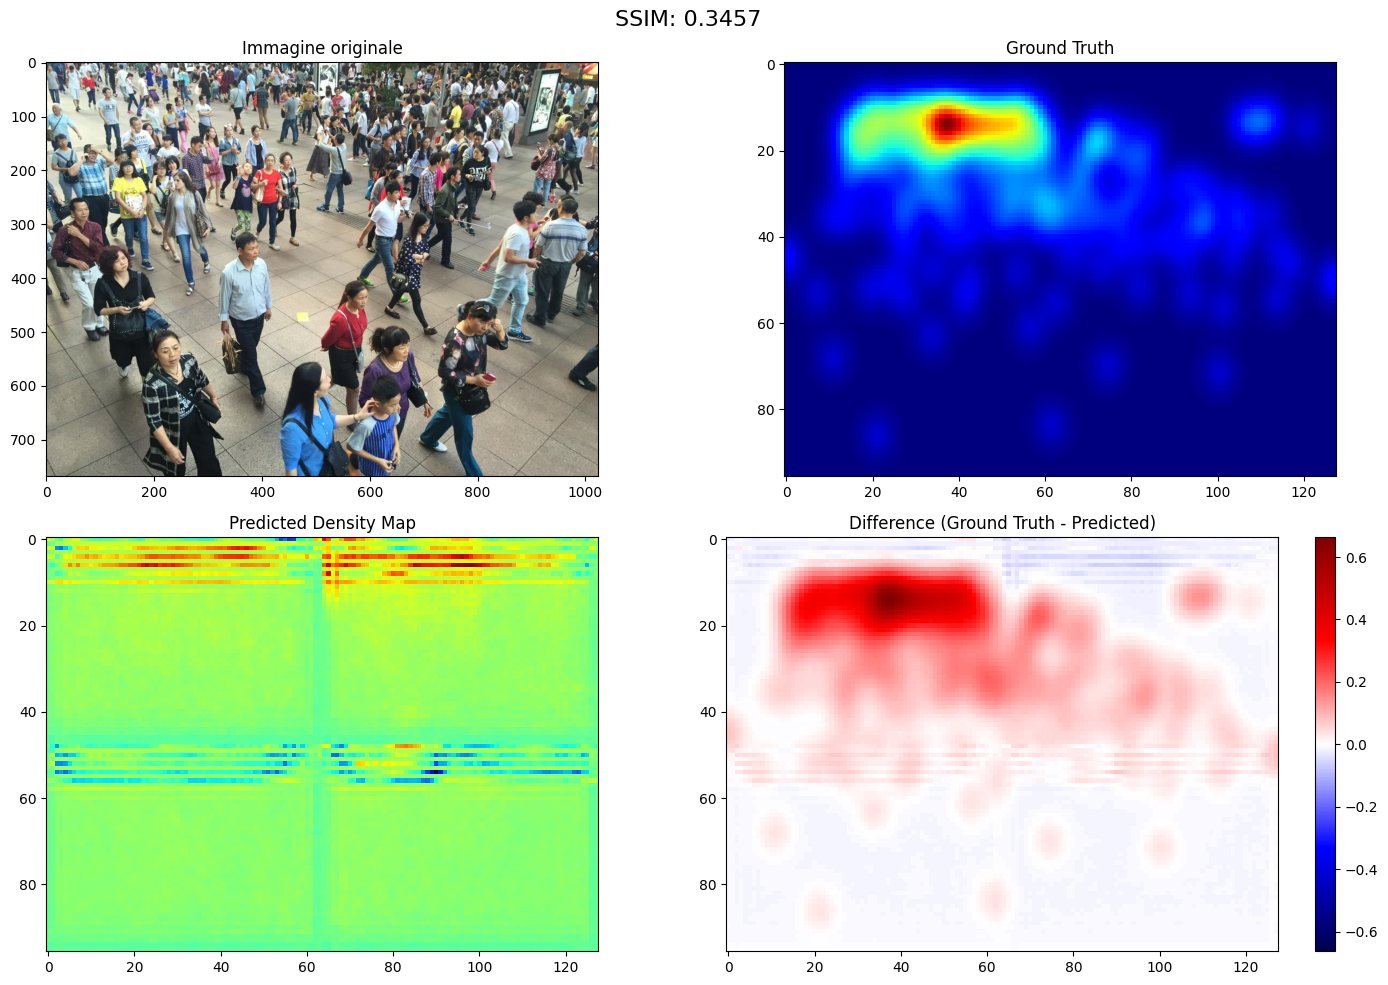

In [101]:
from skimage.metrics import structural_similarity as ssim

# merge density_1, density_2, density_3, density_4 into a unique density map
scaled_h = int(h/8)
scaled_w = int(w/8)
density_map = np.zeros((scaled_h, scaled_w))
half_scaled_h = int(scaled_h/2)
half_scaled_w = int(scaled_w/2)
density_map[:half_scaled_h, :half_scaled_w] = density_1[0][0]
density_map[:half_scaled_h, half_scaled_w:] = density_2[0][0]
density_map[half_scaled_h:, :half_scaled_w] = density_3[0][0]
density_map[half_scaled_h:, half_scaled_w:] = density_4[0][0]
# Ridimensionare il groundtruth per confrontarlo con la density_map
groundtruth_resized = cv2.resize(groundtruth, (scaled_w, scaled_h), interpolation=cv2.INTER_CUBIC)*64
density_map_resized = cv2.resize(density_map, (w, h), interpolation=cv2.INTER_CUBIC)*64
# Calcolo della SSIM
ssim_value = ssim(density_map, groundtruth_resized, data_range=groundtruth_resized.max() - groundtruth_resized.min())
print(f"SSIM tra density_map e groundtruth: {ssim_value:.4f}")

# Visualizzazione dei risultati
plt.figure(figsize=(15, 10))

# Immagine originale
plt.subplot(2, 2, 1)
plt.title("Immagine originale")
plt.imshow(img_real)

# Ground truth
plt.subplot(2, 2, 2)
plt.title("Ground Truth")
plt.imshow(groundtruth_resized, cmap=CM.jet)

# Density map predetta
plt.subplot(2, 2, 3)
plt.title("Predicted Density Map")
plt.imshow(density_map, cmap=CM.jet)

# Differenza tra ground truth e density map
plt.subplot(2, 2, 4)
plt.title("Difference (Ground Truth - Predicted)")
difference_map = groundtruth_resized - density_map
plt.imshow(difference_map, cmap=CM.seismic, vmin=-difference_map.max(), vmax=difference_map.max())
plt.colorbar()

plt.suptitle(f"SSIM: {ssim_value:.4f}", fontsize=16)
plt.tight_layout()
plt.show()


SSIM between density_map and groundtruth: 0.3457


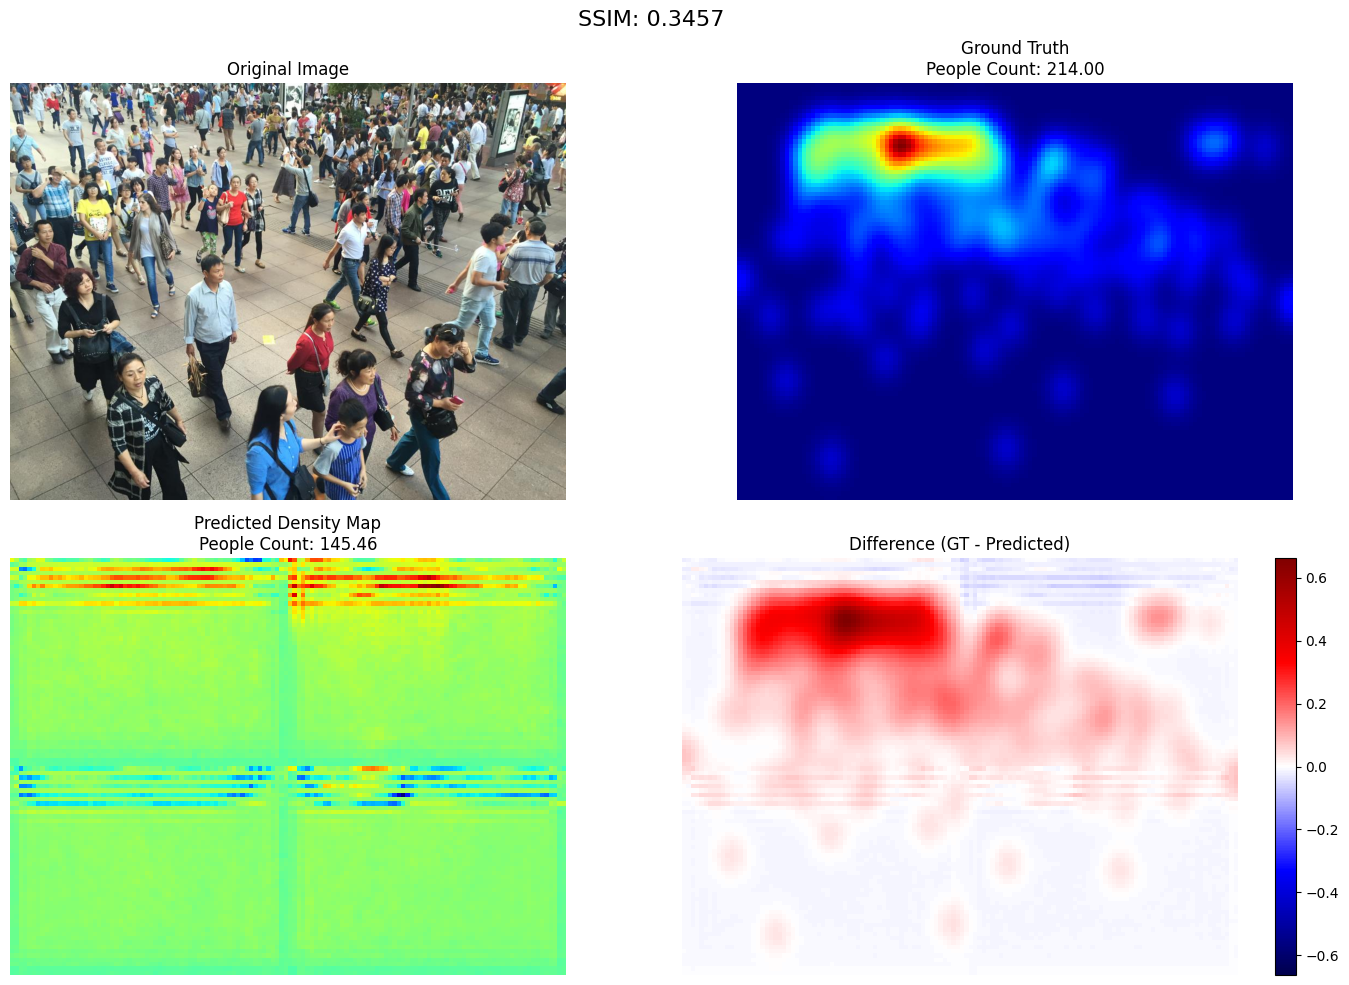

In [89]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as CM

# Merge density_1, density_2, density_3, density_4 into a unique density map
scaled_h = int(h / 8)
scaled_w = int(w / 8)
density_map = np.zeros((scaled_h, scaled_w))
half_scaled_h = int(scaled_h / 2)
half_scaled_w = int(scaled_w / 2)
density_map[:half_scaled_h, :half_scaled_w] = density_1[0][0]
density_map[:half_scaled_h, half_scaled_w:] = density_2[0][0]
density_map[half_scaled_h:, :half_scaled_w] = density_3[0][0]
density_map[half_scaled_h:, half_scaled_w:] = density_4[0][0]

# Resize the ground truth and predicted density map for visualization
groundtruth_resized = cv2.resize(groundtruth, (scaled_w, scaled_h), interpolation=cv2.INTER_CUBIC) * 64
density_map_resized = cv2.resize(density_map, (w, h), interpolation=cv2.INTER_CUBIC) * 64

# Compute SSIM
ssim_value = ssim(density_map, groundtruth_resized, data_range=groundtruth_resized.max() - groundtruth_resized.min())
print(f"SSIM between density_map and groundtruth: {ssim_value:.4f}")

# Compute counts
real_count = groundtruth.sum()
predicted_count = density_map.sum()

# Visualization
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(img_real)
plt.axis('off')

# Ground Truth
plt.subplot(2, 2, 2)
plt.title(f"Ground Truth\nPeople Count: {real_count:.2f}")
plt.imshow(groundtruth_resized, cmap=CM.jet)
plt.axis('off')

# Predicted Density Map
plt.subplot(2, 2, 3)
plt.title(f"Predicted Density Map\nPeople Count: {predicted_count:.2f}")
plt.imshow(density_map, cmap=CM.jet)
plt.axis('off')

# Difference Map
plt.subplot(2, 2, 4)
plt.title("Difference (GT - Predicted)")
difference_map = groundtruth_resized - density_map
plt.imshow(difference_map, cmap=CM.seismic, vmin=-difference_map.max(), vmax=difference_map.max())
plt.colorbar()
plt.axis('off')

plt.suptitle(f"SSIM: {ssim_value:.4f}", fontsize=16)
plt.tight_layout()
plt.show()


In [107]:
import os
import glob
import torch
from torchvision import transforms
from sklearn.metrics import mean_squared_error, mean_absolute_error
from PIL import Image

# Define transformations including resizing
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize all images to 512x512
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Define image folder path
img_folder = '/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/images'
img_paths = []
images=[]
# Load and transform images
for img_path in glob.glob(os.path.join(img_folder, '*.jpg')):
    #print(img_path)
    img = Image.open(img_path).convert('RGB')  # Open image
    images.append(img)
    img = transform(img)  # Apply transformations
    img_paths.append(img)


img_tensors = torch.stack(img_paths)  # Ensure all images have same shape

print(f"Processed {len(img_tensors)} images with shape: {img_tensors.shape}")


Processed 182 images with shape: torch.Size([182, 3, 512, 512])


In [108]:
def test(model, test_data):
    print('\n🧪 Begin Testing')

    test_loader = torch.utils.data.DataLoader(
        ImageDataset(test_data,
            transform=transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ]),
            train=False),
        batch_size=1
    )

    model.eval()

    predictions, ground_truths, similarity_scores = [], [], []
    total_mae, total_mse, total_huber, total_ssim, total_psnr = 0, 0, 0, 0, 0

    progress_bar = tqdm(total=len(test_loader), desc="Testing", position=0, leave=True)

    with torch.no_grad():
        for idx, (input_img, gt_map) in enumerate(test_loader):
            if input_img is None or input_img[0] is None:
                print(f"Skipping index {idx} due to None data.")
                continue
            input_img = input_img.cuda()

            # Skip if ground truth is None or has no content
            if gt_map is None or gt_map.nelement() == 0:
                print(f"⚠️ Skipping image {idx} — ground truth missing.")
                progress_bar.update(1)
                continue

            gt_map = gt_map.type(torch.FloatTensor).cuda()

            pred_map = model(input_img)[:, 0, :, :]

            pred_map_resized = F.interpolate(pred_map.unsqueeze(1), size=gt_map.shape[-2:], mode='bilinear', align_corners=False).squeeze()

            mse = F.mse_loss(pred_map_resized, gt_map).item()
            mae = F.l1_loss(pred_map_resized, gt_map).item()
            huber = F.smooth_l1_loss(pred_map_resized, gt_map).item()

            pred_np = pred_map_resized.squeeze().cpu().numpy()
            gt_np = gt_map.squeeze().cpu().numpy()

            try:
                ssim_score = ssim(gt_np, pred_np, data_range=gt_np.max() - gt_np.min())
            except:
                ssim_score = 0.0
            psnr_score = cv2.PSNR(gt_np, pred_np)

            pred_count = pred_np.sum()
            gt_count = gt_np.sum()

            predictions.append(pred_count)
            ground_truths.append(gt_count)
            similarity_scores.append(ssim_score)

            total_mae += mae
            total_mse += mse
            total_huber += huber
            total_ssim += ssim_score
            total_psnr += psnr_score

            progress_bar.update(1)
            progress_bar.set_postfix({
                "MAE": f"{mae:.2f}",
                "MSE": f"{mse:.2f}",
                "SSIM": f"{ssim_score:.3f}"
            })

    progress_bar.close()

    if len(predictions) == 0:
        print("❌ No valid test samples with ground truth were found.")
        return None

    mae_metric = mean_absolute_error(predictions, ground_truths)
    rmse_metric = np.sqrt(mean_squared_error(predictions, ground_truths))
    avg_huber = total_huber / len(predictions)
    avg_ssim = total_ssim / len(predictions)
    avg_psnr = total_psnr / len(predictions)

    print(f"\n✅ Test Completed:\n"
          f"MAE: {mae_metric:.2f} | RMSE: {rmse_metric:.2f} | "
          f"Huber: {avg_huber:.4f} | SSIM: {avg_ssim:.4f} | PSNR: {avg_psnr:.2f}")

    return mae_metric, rmse_metric, avg_huber, avg_ssim, avg_psnr


In [109]:
import os
import glob
import json

# Path to folder that contains test images
test_img_folder = "/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/images"
saving_path = "/kaggle/working/"

# Output JSON file
output_json = os.path.join(saving_path, "test_imgs.json")

# Get all test images
img_list = []
for img_path in glob.glob(os.path.join(test_img_folder, '*.jpg')):
    img_list.append(img_path)

# Save the image paths to JSON
with open(output_json, 'w') as f:
    json.dump(img_list, f)


In [110]:
import warnings
warnings.filterwarnings("ignore")
with open(saving_path + "/test_imgs.json", 'r') as outfile:
    test_list = json.load(outfile)

test(model_test, test_list)



🧪 Begin Testing


Testing: 100%|██████████| 182/182 [00:09<00:00, 19.26it/s, MAE=0.28, MSE=0.11, SSIM=0.068] 


✅ Test Completed:
MAE: 290.61 | RMSE: 414.76 | Huber: 0.0087 | SSIM: 0.1432 | PSNR: 70.60


(290.60913,
 414.76202,
 0.008704143889749853,
 0.1432143118812676,
 70.60002350066543)

In [116]:
with open(saving_path + "/test_imgs.json", 'r') as outfile:
    test_list = json.load(outfile)

In [119]:
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2
from PIL import Image
import h5py

def visualize_test_samples(model, test_data, num_samples=3):
    print("\n📸 Visualizing Random Predictions")

    test_loader = DataLoader(
        ImageDataset(test_data,
            transform=transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ]),
            train=False),
        batch_size=1,
        shuffle=False
    )

    model.eval()
    samples_data = []

    # Select random indices from test set
    all_indices = list(range(len(test_loader)))
    selected_indices = random.sample(all_indices, min(num_samples, len(all_indices)))

    with torch.no_grad():
        for i, (input_img, gt_map) in enumerate(test_loader):
            if i not in selected_indices:
                continue

            img_tensor = input_img.cuda()
            gt_map = gt_map.cuda()

            pred_map = model(img_tensor)[:, 0, :, :]  # [B, H, W]
            pred_map_resized = F.interpolate(pred_map.unsqueeze(1), size=gt_map.shape[-2:], mode='bilinear', align_corners=False).squeeze()

            pred_np = pred_map_resized.squeeze().cpu().numpy()
            gt_np = gt_map.squeeze().cpu().numpy()

            # Load and preprocess the image (get preprocessed version)
            image_path = test_data[i]  # Assuming the test_data is a list of image paths
            original_image, input_image= load_and_preprocess_data(image_path)

            # Convert preprocessed input image to numpy for visualization
            img_np = np.array(original_image)

            samples_data.append((img_np, pred_np, gt_np))

    # --- Plotting ---
    fig, axes = plt.subplots(len(samples_data), 3, figsize=(15, 5 * len(samples_data)))
    if len(samples_data) == 1:
        axes = np.expand_dims(axes, 0)  # Ensure iterable axes

    for i, (preprocessed_img, pred_map, gt_map) in enumerate(samples_data):
        pred_count = round(pred_map.sum())
        gt_count = round(gt_map.sum())

        axes[i, 0].imshow(preprocessed_img)
        axes[i, 0].set_title("Preprocessed Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(pred_map, cmap='jet')
        axes[i, 1].set_title(f"Predicted Map ({pred_count} people)")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(gt_map, cmap='jet')
        axes[i, 2].set_title(f"Ground Truth Map ({gt_count} people)")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()



📸 Visualizing Random Predictions


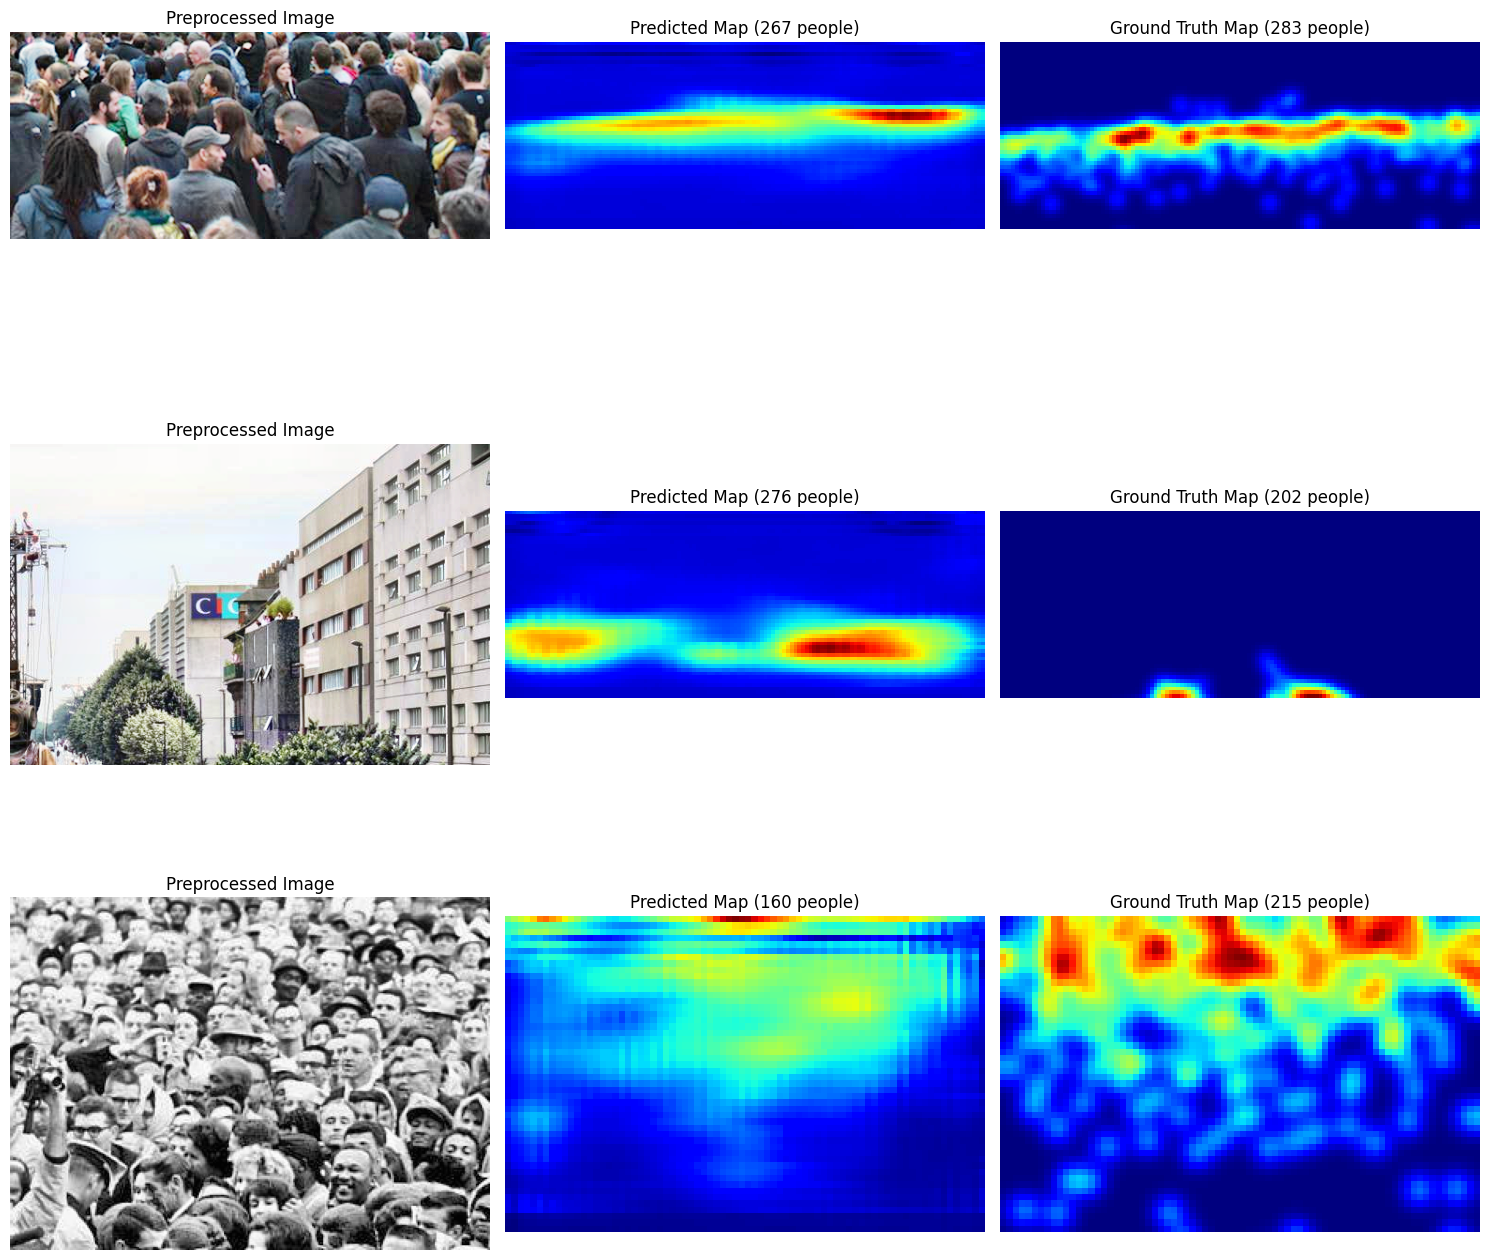

In [121]:
visualize_test_samples(model, test_list, num_samples=3)



📸 Visualizing Random Predictions


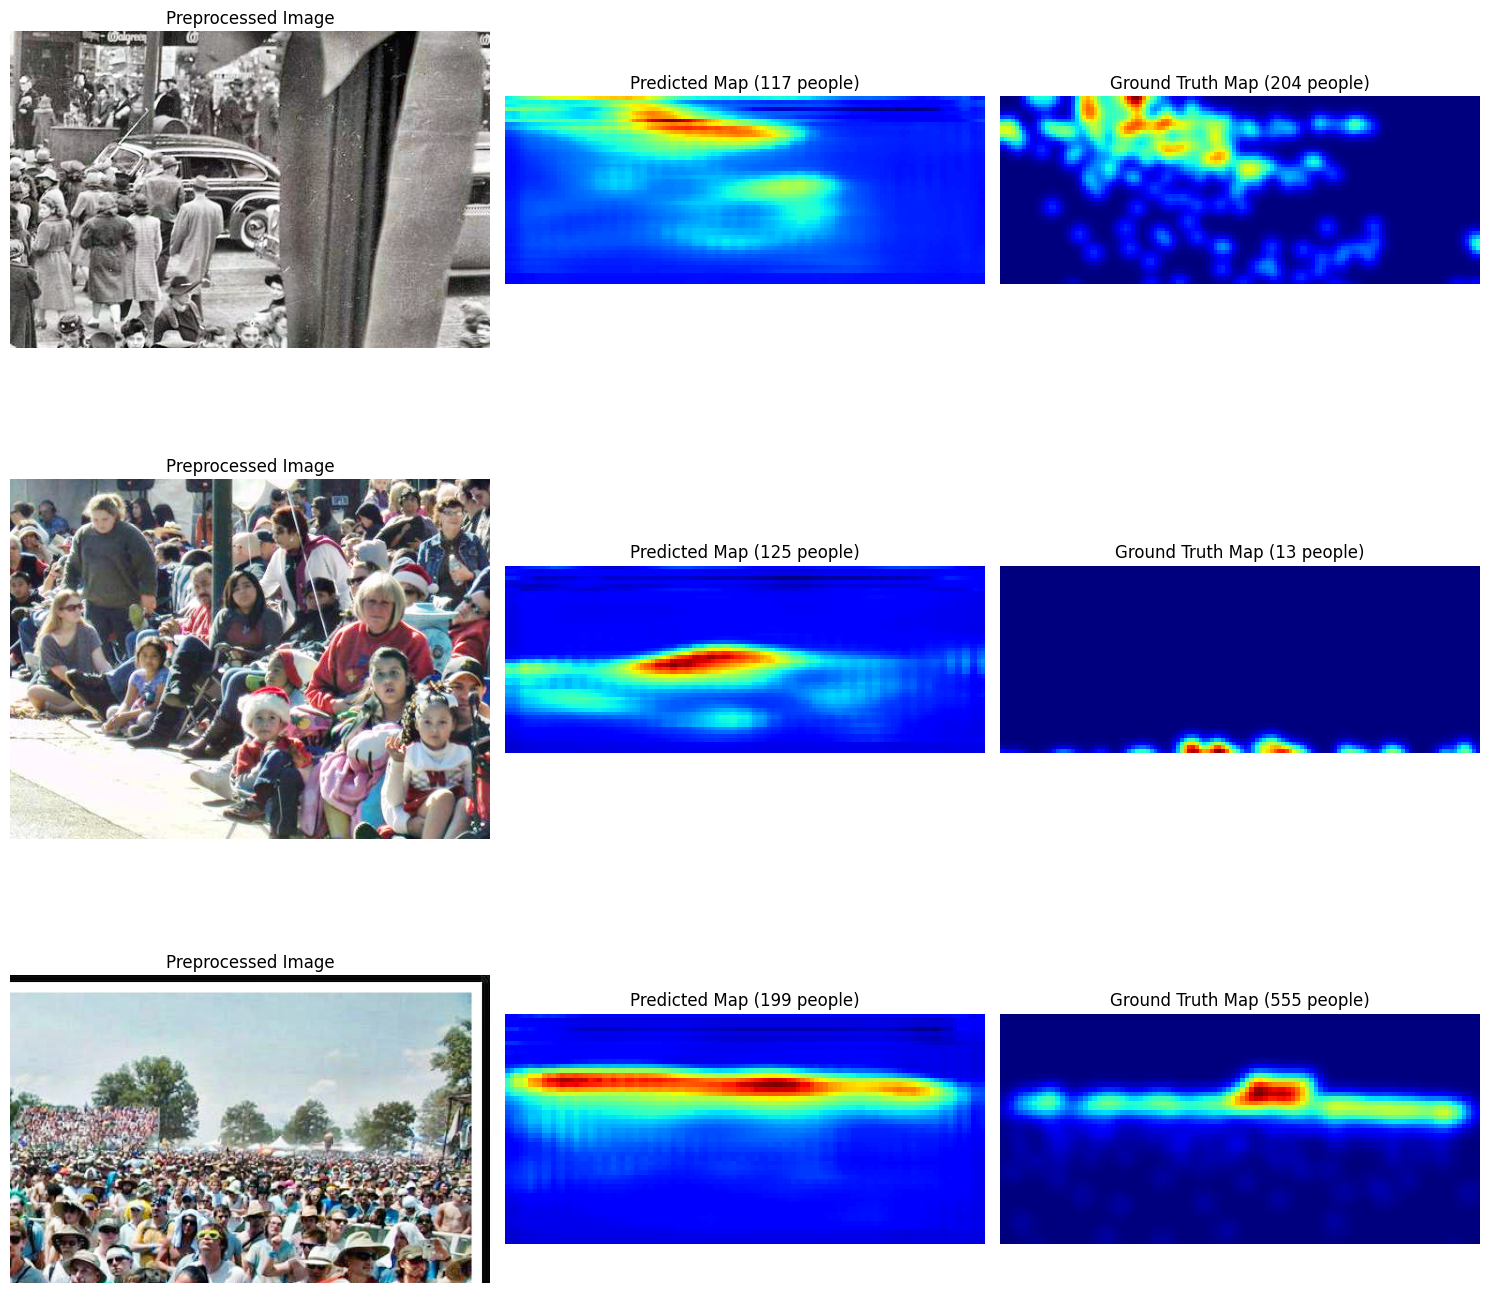

In [88]:
visualize_test_samples(model, test_list, num_samples=3)
